<a href="https://colab.research.google.com/github/gnodking7/PINN-California-Delta/blob/main/5_fold_Results_%26_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

5-fold models obtained using optimal hyperparameters for PINN and optimal hyperparameters for ANN

# Preliminary Setup


## Install Packages

In [ ]:
!pip install -q -U keras-tuner
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.4/150.4 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 13.5 MB/s eta 0:00:00


In [ ]:
import keras_tuner
import numpy as np
import matplotlib.pylab as pl
import deepxde as dde
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import sys
import os
import time

DeepXDE backend not selected or invalid. Use tensorflow.compat.v1.
Using backend: tensorflow.compat.v1

Instructions for updating:
non-resource variables are not supported in the long term


Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Enable just-in-time compilation with XLA.



## Read Data

### Read outflow and salinity data

In [ ]:
### OPTIONAL, if mount manually by tab on left which is less work actually ###
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)

In [ ]:
gdrive_root_path = os.path.join('/content/drive','My Drive','PINN')
sys.path.append(gdrive_root_path)

In [ ]:
sys.path.append('/content/drive/My Drive/MAC/Python')

'''
The data is in an Excel file.
Daily DSM2 outflow and salinity at locations:
  Martinez  Port Chicago  Chipps Island
from Apr 1 1990 to Dec 28 2017
'''
df = pd.read_excel("/content/drive/My Drive/MAC/Python/PortChicago202210.xlsx", header=None)
All = np.asarray(df)
All = All[7:, :]  # Discard headers

for i in range(len(All)):
    All[i, 1] = str(All[i, 1])  # Change dates to str

In [ ]:
def data_pre(year, daily, window, window_len):
    """
    Returns preprocessed outflow data for a given 'year' at locations
    Martinez, Port Chicago, Chipps Island such that
    to each day corresponds outflow data of length 'daily' + 'window'

    The preprocessed outflow data vector is created such that
    first 'daily' number of outflow (including current day) is included
    and prior 'window_len' many outflows are averaged 'window' many times

    PARAMETERS
    ----------
    year :        string or array of strings
                  Outflow year(s)
    daily :       int
                  number of outflow to include 'as-is'
    window :      int
                  number of average windows in return outflow
    window_len :  int
                  length of each window
    RETURNS
    -------
    M_OUT :       ndarray, shape (year length, daily+window)
                  Preprocessed outflow at Martinez
    P_OUT :       ndarray, shape (year length, daily+window)
                  Preprocessed outflow at Port Chicago
    C_OUT :       ndarray, shape (year length, daily+window)
                  Preprocessed outflow at Chipps Island
    """

    if type(year) == str:
        indices = np.flatnonzero(np.core.defchararray.find(list(All[:, 1]), year)!=-1)
    else:
        indices = []
        for yr in year:
            indices.extend(np.flatnonzero(np.core.defchararray.find(list(All[:, 1]), yr)!=-1))
    total = daily + window * window_len
    OUT_d = All[indices[0] - (total - 1):indices[-1] + 1, 2:5] # Range of outflow to extract outflow vector from
    OUT_d = np.flip(OUT_d, 1) # Locations are in reverse order, so flip data
    OUT_d = (OUT_d - np.min(OUT_d)) / (np.max(OUT_d) - np.min(OUT_d)) # Normalize

    ## Preprocessed outflow data for Martinez
    M_OUT = []
    cur = total - 1
    for i in range(len(indices)):
        vec = OUT_d[cur-(daily-1):cur+1, 0]
        vec = np.flip(vec)
        ind = cur - (daily - 1)
        for j in range(window):
            avg = np.mean(OUT_d[ind-window_len:ind, 0])
            vec = np.concatenate((vec, np.array([avg])))
            ind -= window_len
        M_OUT.append(vec)
        cur += 1
    M_OUT = np.array(M_OUT)

    ## Preprocessed outflow data for Port Chicago
    P_OUT = []
    cur = total - 1
    for i in range(len(indices)):
        vec = OUT_d[cur-(daily-1):cur+1, 1]
        vec = np.flip(vec)
        ind = cur - (daily - 1)
        for j in range(window):
            avg = np.mean(OUT_d[ind-window_len:ind, 1])
            vec = np.concatenate((vec, np.array([avg])))
            ind -= window_len
        P_OUT.append(vec)
        cur += 1
    P_OUT = np.array(P_OUT)

    ## Preprocessed outflow data for Chipps Island
    C_OUT = []
    cur = total - 1
    for i in range(len(indices)):
        vec = OUT_d[cur-(daily-1):cur+1, 2]
        vec = np.flip(vec)
        ind = cur - (daily - 1)
        for j in range(window):
            avg = np.mean(OUT_d[ind-window_len:ind, 2])
            vec = np.concatenate((vec, np.array([avg])))
            ind -= window_len
        C_OUT.append(vec)
        cur += 1
    C_OUT = np.array(C_OUT)

    return M_OUT, P_OUT, C_OUT

### Preprocess to create outflow vectors

In [ ]:
# years = ['1991','1992','1993','1994','1995','1996','1997','1998','1999','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017']
years = ['1991','1992','1993','1994','1995','1996','1997','1998','1999','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015']

indices = []
for yr in years:
    indices.extend(np.flatnonzero(np.core.defchararray.find(list(All[:, 1]), yr)!=-1))
indices = np.array(indices)

EC_d = All[indices, 5:] # Salinity at three locations
EC_min = np.min(EC_d)
EC_max = np.max(EC_d)

'''
Create outflow data vectors at each location
To each day corresponds a 18-dim vector created from antecedent 118 outflow data:
  current day + previous 7 days + previous 110 days averaged into 10-dim values with window length 11
'''
M_OUT, P_OUT, C_OUT = data_pre(years, 8, 10, 11)

### Split data to 5-fold

In [ ]:
def data_split(years, k):
    """
    Returns split EC data and inputs for ANN and PINN for each k-fold.

    PARAMETERS
    ----------
    years:     list of strings 
               indicates data years
    k:         int
               k-fold number
    RETURNS
    -------
    DATA_SET:  length k Hash Table with integer 1,2,...,k as keys
               each item contains a Hash Table of the following data:

               tr_indices:    ndarray (_)
                              training indices
               tst_indices:   ndarray (_)
                              testing indices
               tr_EC_d:       ndarray (_, 3)
                              training EC at three locations
               tst_EC_d:      ndarray (_, 3)
                              testing EC at three locations
               Q:             ndarray (_, 18)
                              training outflow inputs for ANN
               Q_tst:         ndarray (_, 18)
                              testing outflow inputs for ANN
               X:             ndarray (_, 20)
                              training inputs for PINN
               X_tst:         ndarray (_, 20)
                              testing inputs for PINN
               Svals:         ndarray (_)
                              training EC array
               Svals_tst:     ndarray (_)
                              testing EC array
    """
    DATA_SET = dict()
    TST_YEARS = np.split(np.array(years), k)  # split years into k folds

    cur_fold = 1

    for tst_years in TST_YEARS:
        tr_years = np.setdiff1d(years, tst_years)
        tr_indices = []
        for yr in tr_years:
            tr_indices.extend(np.flatnonzero(np.core.defchararray.find(list(All[:, 1]), yr)!=-1))
        tr_indices = np.array(tr_indices)

        tst_indices = []
        for yr in tst_years:
            tst_indices.extend(np.flatnonzero(np.core.defchararray.find(list(All[:, 1]), yr)!=-1))
        tst_indices = np.array(tst_indices)

        ## Training data
        tr_EC_d = All[tr_indices, 5:]
        tr_EC_d = np.flip(tr_EC_d, 1)
        tr_EC_d = (tr_EC_d - EC_min) / (EC_max - EC_min) # Normalize

        Q = []  # Inputs for ANN
        X = []  # Inputs for PINN
        Svals = []  # Outputs (same for both ANN and PINN)

        portion = 1 / (len(tr_indices) + len(tst_indices)) # to split the time domain [0, 1] uniformly

        for i in range(len(tr_EC_d)):
            cur_ind = tr_indices[i]
            for j in range(3):
                # Martinez
                if j == 0:
                    Q.append(M_OUT[cur_ind-275, :])
                    X.append(np.concatenate(([0, (cur_ind - 274) * portion], M_OUT[cur_ind-275, :])))
                # Port Chicago
                elif j == 1:
                    Q.append(P_OUT[cur_ind-275, :])
                    X.append(np.concatenate(([0.442, (cur_ind - 274) * portion], P_OUT[cur_ind-275, :])))
                # Chipps Island
                elif j == 2:
                    Q.append(C_OUT[cur_ind-275, :])
                    X.append(np.concatenate(([1, (cur_ind - 274) * portion], C_OUT[cur_ind-275, :])))
                Svals.append(tr_EC_d[i, j])

        Q = np.array(Q).astype('float32')
        X = np.array(X).astype('float32')
        Svals = np.array(Svals).astype('float32').flatten()[:, None]

        ## Testing data
        tst_EC_d = All[tst_indices, 5:]
        tst_EC_d = np.flip(tst_EC_d, 1)
        tst_EC_d = (tst_EC_d - EC_min) / (EC_max - EC_min) # Normalize

        Q_tst = []  # Validation inputs for ANN
        X_tst = []  # Validation inputs for PINN
        Svals_tst = []  # Validation outputs

        for i in range(len(tst_EC_d)):
            cur_ind = tst_indices[i]
            for j in range(3):
                # Martinez
                if j == 0:
                    Q_tst.append(M_OUT[cur_ind-275, :])
                    X_tst.append(np.concatenate(([0, (cur_ind - 274) * portion], M_OUT[cur_ind-275, :])))
                # Port Chicago
                elif j == 1:
                    Q_tst.append(P_OUT[cur_ind-275, :])
                    X_tst.append(np.concatenate(([0.442, (cur_ind - 274) * portion], P_OUT[cur_ind-275, :])))
                # Chipps Island
                elif j == 2:
                    Q_tst.append(C_OUT[cur_ind-275, :])
                    X_tst.append(np.concatenate(([1, (cur_ind - 274) * portion], C_OUT[cur_ind-275, :])))
                Svals_tst.append(tst_EC_d[i, j])

        Q_tst = np.array(Q_tst).astype('float32')
        X_tst = np.array(X_tst).astype('float32')
        Svals_tst = np.array(Svals_tst).astype('float32').flatten()[:, None]

        DATA_SET[cur_fold] = {'tr_indices':tr_indices, 'tst_indices':tst_indices, 'tr_EC_d':tr_EC_d, 'tst_EC_d':tst_EC_d, 
                              'Q':Q, 'Q_tst':Q_tst, 'X':X, 'X_tst':X_tst, 'Svals':Svals, 'Svals_tst':Svals_tst}
        cur_fold += 1

    return DATA_SET 

In [ ]:
DATA_SET = data_split(years, 5)

## Define Evaluation Metrics

In [ ]:
## Evaluation metrics
from collections import defaultdict
eval_metrics = ['MSE', 'Bias', 'R', 'RMSD', 'NSE', 'L2', 'RSR']

def evaluate_sequences(target, pred, metrics):
    assert len(target) == len(pred), 'Target and predicted sequence length must equal.'
    valid_entries = target>0
    sequence_length = np.sum(valid_entries)
    if np.any(sequence_length == 0):
        return {k: 0 for k in metrics}
    target=target[valid_entries]
    pred = pred[valid_entries]
    SD_pred = np.sqrt( np.sum((pred-np.mean(pred)) ** 2) /(sequence_length-1))
    SD_target = np.sqrt( np.sum((target-np.mean(target)) ** 2) /(sequence_length-1))

    eval_results = defaultdict(float)
    
    for m in metrics:
        if m =='MSE':
            eval_results[m] = ((target - pred)**2).mean()
        elif m =='Bias':
            eval_results[m] = np.sum(pred - target)/np.sum(target) * 100
        elif m == 'R':
            eval_results[m] = np.sum(np.abs((pred-np.mean(pred)) * (target - np.mean(target)))) / (sequence_length * SD_pred * SD_target)
        elif m == 'RMSD':
            eval_results[m] = np.sqrt(np.sum( ( ( pred-np.mean(pred) ) * ( target - np.mean(target) ) ) ** 2 ) / sequence_length)
        elif m == 'NSE':
            eval_results[m] = 1 - np.sum( ( target - pred ) ** 2 ) / np.sum( (target - np.mean(target) ) ** 2 )
        elif m == 'L2':
            eval_results[m] = dde.metrics.l2_relative_error(target, pred)
        elif m == 'RSR':
            eval_results[m] = np.sqrt( np.sum( (target - pred) ** 2 ) / np.sum( (target - np.mean(target)) ** 2) )
    return eval_results

# Load Models


## 5-fold (Test: 1991-1995)

In [ ]:
# Load model (if saved already)
model_path_prefix = "ANN_5fold_1 (ANN_best)"
model_savepath = os.path.join(gdrive_root_path, 'models', (model_path_prefix))
ANN_model1 = keras.models.load_model(model_savepath)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
# Load model (if saved already)
model_path_prefix = "PINN_5fold_1"
model_savepath = os.path.join(gdrive_root_path, 'models', (model_path_prefix))
PINN_model1 = keras.models.load_model(model_savepath, compile=False)  # compile=False necessary for custom loss issue

In [ ]:
print('Hyperparameters for ANN\n')
print('Activation 1:', ANN_model1.get_config()['layers'][1]['config']['activation'])
print('Activation 2:', ANN_model1.get_config()['layers'][2]['config']['activation'])
print('Activation 3:', ANN_model1.get_config()['layers'][3]['config']['activation'])
print('nhidden 1:', ANN_model1.get_config()['layers'][1]['config']['units'])
print('nhidden2:', ANN_model1.get_config()['layers'][2]['config']['units'])

Hyperparameters for ANN

Activation 1: tanh
Activation 2: relu
Activation 3: sigmoid
nhidden 1: 20
nhidden2: 16


In [ ]:
print('Hyperparameters for PINN\n')
print('Activation 1:', PINN_model1.get_config()['layers'][1]['config']['activation'])
print('Activation 2:', PINN_model1.get_config()['layers'][2]['config']['activation'])
print('Activation 3:', PINN_model1.get_config()['layers'][3]['config']['activation'])
print('nhidden 1:', PINN_model1.get_config()['layers'][1]['config']['units'])
print('nhidden2:', PINN_model1.get_config()['layers'][2]['config']['units'])

Hyperparameters for PINN

Activation 1: elu
Activation 2: relu
Activation 3: elu
nhidden 1: 8
nhidden2: 12


## 5-fold (Test: 1996-2000)

In [ ]:
# Load model (if saved already)
model_path_prefix = "ANN_5fold_2 (ANN_best)"
model_savepath = os.path.join(gdrive_root_path, 'models', (model_path_prefix))
ANN_model2 = keras.models.load_model(model_savepath)

In [ ]:
# Load model (if saved already)
model_path_prefix = "PINN_5fold_2"
model_savepath = os.path.join(gdrive_root_path, 'models', (model_path_prefix))
PINN_model2 = keras.models.load_model(model_savepath, compile=False)  # compile=False necessary for custom loss issue

In [ ]:
print('Hyperparameters for ANN\n')
print('Activation 1:', ANN_model2.get_config()['layers'][1]['config']['activation'])
print('Activation 2:', ANN_model2.get_config()['layers'][2]['config']['activation'])
print('Activation 3:', ANN_model2.get_config()['layers'][3]['config']['activation'])
print('nhidden 1:', ANN_model2.get_config()['layers'][1]['config']['units'])
print('nhidden2:', ANN_model2.get_config()['layers'][2]['config']['units'])

Hyperparameters for ANN

Activation 1: elu
Activation 2: elu
Activation 3: sigmoid
nhidden 1: 32
nhidden2: 8


In [ ]:
print('Hyperparameters for PINN\n')
print('Activation 1:', PINN_model2.get_config()['layers'][1]['config']['activation'])
print('Activation 2:', PINN_model2.get_config()['layers'][2]['config']['activation'])
print('Activation 3:', PINN_model2.get_config()['layers'][3]['config']['activation'])
print('nhidden 1:', PINN_model2.get_config()['layers'][1]['config']['units'])
print('nhidden2:', PINN_model2.get_config()['layers'][2]['config']['units'])

Hyperparameters for PINN

Activation 1: relu
Activation 2: tanh
Activation 3: tanh
nhidden 1: 32
nhidden2: 10


## 5-fold (Test: 2001-2005)

In [ ]:
# Load model (if saved already)
model_path_prefix = "ANN_5fold_3 (ANN_best)"
model_savepath = os.path.join(gdrive_root_path, 'models', (model_path_prefix))
ANN_model3 = keras.models.load_model(model_savepath)

In [ ]:
# Load model (if saved already)
model_path_prefix = "PINN_5fold_3"
model_savepath = os.path.join(gdrive_root_path, 'models', (model_path_prefix))
PINN_model3 = keras.models.load_model(model_savepath, compile=False)  # compile=False necessary for custom loss issue

In [ ]:
print('Hyperparameters for ANN\n')
print('Activation 1:', ANN_model3.get_config()['layers'][1]['config']['activation'])
print('Activation 2:', ANN_model3.get_config()['layers'][2]['config']['activation'])
print('Activation 3:', ANN_model3.get_config()['layers'][3]['config']['activation'])
print('nhidden 1:', ANN_model3.get_config()['layers'][1]['config']['units'])
print('nhidden2:', ANN_model3.get_config()['layers'][2]['config']['units'])

Hyperparameters for ANN

Activation 1: relu
Activation 2: sigmoid
Activation 3: tanh
nhidden 1: 20
nhidden2: 6


In [ ]:
print('Hyperparameters for PINN\n')
print('Activation 1:', PINN_model3.get_config()['layers'][1]['config']['activation'])
print('Activation 2:', PINN_model3.get_config()['layers'][2]['config']['activation'])
print('Activation 3:', PINN_model3.get_config()['layers'][3]['config']['activation'])
print('nhidden 1:', PINN_model3.get_config()['layers'][1]['config']['units'])
print('nhidden2:', PINN_model3.get_config()['layers'][2]['config']['units'])

Hyperparameters for PINN

Activation 1: relu
Activation 2: elu
Activation 3: tanh
nhidden 1: 16
nhidden2: 10


## 5-fold (Test: 2006-2010)

In [ ]:
# Load model (if saved already)
model_path_prefix = "ANN_5fold_4 (ANN_best)"
model_savepath = os.path.join(gdrive_root_path, 'models', (model_path_prefix))
ANN_model4 = keras.models.load_model(model_savepath)

In [ ]:
# Load model (if saved already)
model_path_prefix = "PINN_5fold_4"
model_savepath = os.path.join(gdrive_root_path, 'models', (model_path_prefix))
PINN_model4 = keras.models.load_model(model_savepath, compile=False)  # compile=False necessary for custom loss issue

In [ ]:
print('Hyperparameters for ANN\n')
print('Activation 1:', ANN_model4.get_config()['layers'][1]['config']['activation'])
print('Activation 2:', ANN_model4.get_config()['layers'][2]['config']['activation'])
print('Activation 3:', ANN_model4.get_config()['layers'][3]['config']['activation'])
print('nhidden 1:', ANN_model4.get_config()['layers'][1]['config']['units'])
print('nhidden2:', ANN_model4.get_config()['layers'][2]['config']['units'])

Hyperparameters for ANN

Activation 1: tanh
Activation 2: sigmoid
Activation 3: sigmoid
nhidden 1: 20
nhidden2: 8


In [ ]:
print('Hyperparameters for PINN\n')
print('Activation 1:', PINN_model4.get_config()['layers'][1]['config']['activation'])
print('Activation 2:', PINN_model4.get_config()['layers'][2]['config']['activation'])
print('Activation 3:', PINN_model4.get_config()['layers'][3]['config']['activation'])
print('nhidden 1:', PINN_model4.get_config()['layers'][1]['config']['units'])
print('nhidden2:', PINN_model4.get_config()['layers'][2]['config']['units'])

Hyperparameters for PINN

Activation 1: tanh
Activation 2: relu
Activation 3: sigmoid
nhidden 1: 24
nhidden2: 14


## 5-fold (Test: 2011-2015)

In [ ]:
# Load model (if saved already)
model_path_prefix = "ANN_5fold_5 (ANN_best)"
model_savepath = os.path.join(gdrive_root_path, 'models', (model_path_prefix))
ANN_model5 = keras.models.load_model(model_savepath)

In [ ]:
# Load model (if saved already)
model_path_prefix = "PINN_5fold_5"
model_savepath = os.path.join(gdrive_root_path, 'models', (model_path_prefix))
PINN_model5 = keras.models.load_model(model_savepath, compile=False)  # compile=False necessary for custom loss issue

In [ ]:
print('Hyperparameters for ANN\n')
print('Activation 1:', ANN_model5.get_config()['layers'][1]['config']['activation'])
print('Activation 2:', ANN_model5.get_config()['layers'][2]['config']['activation'])
print('Activation 3:', ANN_model5.get_config()['layers'][3]['config']['activation'])
print('nhidden 1:', ANN_model5.get_config()['layers'][1]['config']['units'])
print('nhidden2:', ANN_model5.get_config()['layers'][2]['config']['units'])

Hyperparameters for ANN

Activation 1: elu
Activation 2: tanh
Activation 3: sigmoid
nhidden 1: 32
nhidden2: 14


In [ ]:
print('Hyperparameters for PINN\n')
print('Activation 1:', PINN_model5.get_config()['layers'][1]['config']['activation'])
print('Activation 2:', PINN_model5.get_config()['layers'][2]['config']['activation'])
print('Activation 3:', PINN_model5.get_config()['layers'][3]['config']['activation'])
print('nhidden 1:', PINN_model5.get_config()['layers'][1]['config']['units'])
print('nhidden2:', PINN_model5.get_config()['layers'][2]['config']['units'])

Hyperparameters for PINN

Activation 1: relu
Activation 2: tanh
Activation 3: tanh
nhidden 1: 28
nhidden2: 14


# Obtain evaluation results & time series

In [ ]:
def eval_res(PINN_model, ANN_model, k):
    """
    Returns evaluation metric results and time series at three locations for kth fold

    PARAMETERS
    ----------
    k:            int
                  kth fold
    PINN_model:   Keras model
    ANN_model:    Keras model
    RETURNS
    -------
    RESULTS:      length 3 Hash Table with three locations as keys
                  each item contains a Hash Table of the following data:

                  PINN_timeseries
                  ANN_timeseries
                  PINN_results
                  ANN_results
    """

    RESULTS = dict()

    tr_indices, tst_indices = DATA_SET[k]['tr_indices'], DATA_SET[k]['tst_indices']
    tst_EC_d = DATA_SET[k]['tst_EC_d']

    portion = 1 / (len(tr_indices) + len(tst_indices)) # to split the time domain [0, 1] uniformly

    ## At Martinez

    Q, X = [], []

    for i in range(len(tst_EC_d)):
        cur_ind = tst_indices[i]
        Q.append(M_OUT[cur_ind-275, :])
        X.append(np.concatenate(([0, (cur_ind - 274) * portion], M_OUT[cur_ind-275, :])))

    Q, X = np.array(Q), np.array(X)

    PINN_timeseries = np.maximum(PINN_model.predict(X), 0)[:, 0]
    PINN_results = evaluate_sequences(tst_EC_d[:, 0][:, None], PINN_timeseries[:, None], eval_metrics)
    ANN_timeseries = np.maximum(ANN_model.predict(Q), 0)[:, 0]
    ANN_results = evaluate_sequences(tst_EC_d[:, 0][:, None], ANN_timeseries[:, None], eval_metrics)

    RESULTS['Martinez'] = {'PINN_timeseries':PINN_timeseries,
                           'ANN_timeseries':ANN_timeseries,
                           'PINN_results':PINN_results,
                           'ANN_results':ANN_results}

    ## At Port Chicago

    Q, X = [], []

    for i in range(len(tst_EC_d)):
        cur_ind = tst_indices[i]
        Q.append(P_OUT[cur_ind-275, :])
        X.append(np.concatenate(([0.442, (cur_ind - 274) * portion], P_OUT[cur_ind-275, :])))

    Q, X = np.array(Q), np.array(X)

    PINN_timeseries = np.maximum(PINN_model.predict(X), 0)[:, 0]
    PINN_results = evaluate_sequences(tst_EC_d[:, 1][:, None], PINN_timeseries[:, None], eval_metrics)
    ANN_timeseries = np.maximum(ANN_model.predict(Q), 0)[:, 0]
    ANN_results = evaluate_sequences(tst_EC_d[:, 1][:, None], ANN_timeseries[:, None], eval_metrics)

    RESULTS['Port Chicago'] = {'PINN_timeseries':PINN_timeseries,
                           'ANN_timeseries':ANN_timeseries,
                           'PINN_results':PINN_results,
                           'ANN_results':ANN_results}

    ## At Chipps Island

    Q, X = [], []

    for i in range(len(tst_EC_d)):
        cur_ind = tst_indices[i]
        Q.append(C_OUT[cur_ind-275, :])
        X.append(np.concatenate(([1, (cur_ind - 274) * portion], C_OUT[cur_ind-275, :])))

    Q, X = np.array(Q), np.array(X)

    PINN_timeseries = np.maximum(PINN_model.predict(X), 0)[:, 0]
    PINN_results = evaluate_sequences(tst_EC_d[:, 2][:, None], PINN_timeseries[:, None], eval_metrics)
    ANN_timeseries = np.maximum(ANN_model.predict(Q), 0)[:, 0]
    ANN_results = evaluate_sequences(tst_EC_d[:, 2][:, None], ANN_timeseries[:, None], eval_metrics)

    RESULTS['Chipps Island'] = {'PINN_timeseries':PINN_timeseries,
                           'ANN_timeseries':ANN_timeseries,
                           'PINN_results':PINN_results,
                           'ANN_results':ANN_results}

    return RESULTS

In [ ]:
RESULTS1 = eval_res(PINN_model1, ANN_model1, 1)
RESULTS2 = eval_res(PINN_model2, ANN_model2, 2)
RESULTS3 = eval_res(PINN_model3, ANN_model3, 3)
RESULTS4 = eval_res(PINN_model4, ANN_model4, 4)
RESULTS5 = eval_res(PINN_model5, ANN_model5, 5)

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
RESULTS1['Martinez']

{'PINN_timeseries': array([0.7942806 , 0.790858  , 0.7724741 , ..., 0.13186184, 0.14797801,
        0.14709055], dtype=float32),
 'ANN_timeseries': array([0.7367683 , 0.74489266, 0.7418066 , ..., 0.07351836, 0.08502976,
        0.09079564], dtype=float32),
 'PINN_results': defaultdict(float,
             {'MSE': 0.0063216363331791816,
              'Bias': -2.419726395429468,
              'R': 0.9790823518478033,
              'RMSD': 0.1095349478365925,
              'NSE': 0.9356928108489093,
              'L2': 0.133785072472446,
              'RSR': 0.2535886218880702}),
 'ANN_results': defaultdict(float,
             {'MSE': 0.00749870623696751,
              'Bias': -10.324576306344913,
              'R': 0.9832946397535584,
              'RMSD': 0.11083482858828228,
              'NSE': 0.9237190032842933,
              'L2': 0.1457088981988869,
              'RSR': 0.27619014594244057})}

# Plots

## Scatter plots for evaluation metrics

In [ ]:
## For adding the line x=y

def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

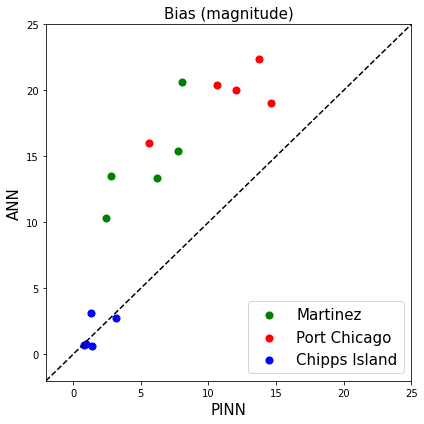

In [ ]:
## Bias
f, ax = pl.subplots(figsize=(6, 6))

ax.scatter(abs(RESULTS1['Martinez']['PINN_results']['Bias']), abs(RESULTS1['Martinez']['ANN_results']['Bias']), s=50, c='g', label='Martinez')
ax.scatter(abs(RESULTS2['Martinez']['PINN_results']['Bias']), abs(RESULTS2['Martinez']['ANN_results']['Bias']), s=50, c='g')
ax.scatter(abs(RESULTS3['Martinez']['PINN_results']['Bias']), abs(RESULTS3['Martinez']['ANN_results']['Bias']), s=50, c='g')
ax.scatter(abs(RESULTS4['Martinez']['PINN_results']['Bias']), abs(RESULTS4['Martinez']['ANN_results']['Bias']), s=50, c='g')
ax.scatter(abs(RESULTS5['Martinez']['PINN_results']['Bias']), abs(RESULTS5['Martinez']['ANN_results']['Bias']), s=50, c='g')

ax.scatter(abs(RESULTS1['Port Chicago']['PINN_results']['Bias']), abs(RESULTS1['Port Chicago']['ANN_results']['Bias']), s=50, c='r', label='Port Chicago')
ax.scatter(abs(RESULTS2['Port Chicago']['PINN_results']['Bias']), abs(RESULTS2['Port Chicago']['ANN_results']['Bias']), s=50, c='r')
ax.scatter(abs(RESULTS3['Port Chicago']['PINN_results']['Bias']), abs(RESULTS3['Port Chicago']['ANN_results']['Bias']), s=50, c='r')
ax.scatter(abs(RESULTS4['Port Chicago']['PINN_results']['Bias']), abs(RESULTS4['Port Chicago']['ANN_results']['Bias']), s=50, c='r')
ax.scatter(abs(RESULTS5['Port Chicago']['PINN_results']['Bias']), abs(RESULTS5['Port Chicago']['ANN_results']['Bias']), s=50, c='r')

ax.scatter(abs(RESULTS1['Chipps Island']['PINN_results']['Bias']), abs(RESULTS1['Chipps Island']['ANN_results']['Bias']), s=50, c='b', label='Chipps Island')
ax.scatter(abs(RESULTS2['Chipps Island']['PINN_results']['Bias']), abs(RESULTS2['Chipps Island']['ANN_results']['Bias']), s=50, c='b')
ax.scatter(abs(RESULTS3['Chipps Island']['PINN_results']['Bias']), abs(RESULTS3['Chipps Island']['ANN_results']['Bias']), s=50, c='b')
ax.scatter(abs(RESULTS4['Chipps Island']['PINN_results']['Bias']), abs(RESULTS4['Chipps Island']['ANN_results']['Bias']), s=50, c='b')
ax.scatter(abs(RESULTS5['Chipps Island']['PINN_results']['Bias']), abs(RESULTS5['Chipps Island']['ANN_results']['Bias']), s=50, c='b')

lower, upper = np.floor(min(min(ax.get_xlim()), min(ax.get_ylim()))) - 1, np.ceil(max(max(ax.get_xlim()), max(ax.get_ylim()))) + 1
ax.set(xlim=(lower, upper), ylim=(lower, upper))
add_identity(ax, color='k', ls='--')

pl.title('Bias (magnitude)', fontsize=15)
pl.xlabel('PINN', fontsize=15)
pl.ylabel('ANN', fontsize=15)
pl.legend(fontsize=15)
pl.tight_layout()

In [ ]:
## Save plots

fig_savepath = os.path.join(gdrive_root_path, "images/5-fold", "Bias" + "M+P+C_test (Best)")
f.savefig(fig_savepath, bbox_inches='tight',dpi=300)

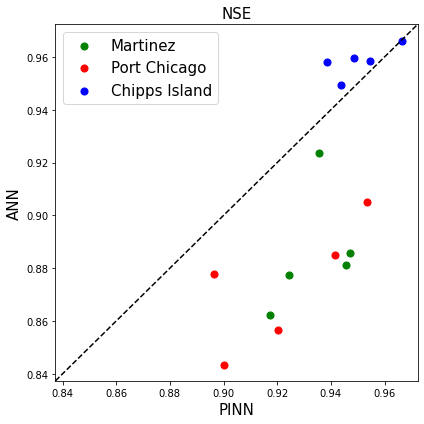

In [ ]:
## NSE
f, ax = pl.subplots(figsize=(6, 6))

ax.scatter(RESULTS1['Martinez']['PINN_results']['NSE'], RESULTS1['Martinez']['ANN_results']['NSE'], s=50, c='g', label='Martinez')
ax.scatter(RESULTS2['Martinez']['PINN_results']['NSE'], RESULTS2['Martinez']['ANN_results']['NSE'], s=50, c='g')
ax.scatter(RESULTS3['Martinez']['PINN_results']['NSE'], RESULTS3['Martinez']['ANN_results']['NSE'], s=50, c='g')
ax.scatter(RESULTS4['Martinez']['PINN_results']['NSE'], RESULTS4['Martinez']['ANN_results']['NSE'], s=50, c='g')
ax.scatter(RESULTS5['Martinez']['PINN_results']['NSE'], RESULTS5['Martinez']['ANN_results']['NSE'], s=50, c='g')

ax.scatter(RESULTS1['Port Chicago']['PINN_results']['NSE'], RESULTS1['Port Chicago']['ANN_results']['NSE'], s=50, c='r', label='Port Chicago')
ax.scatter(RESULTS2['Port Chicago']['PINN_results']['NSE'], RESULTS2['Port Chicago']['ANN_results']['NSE'], s=50, c='r')
ax.scatter(RESULTS3['Port Chicago']['PINN_results']['NSE'], RESULTS3['Port Chicago']['ANN_results']['NSE'], s=50, c='r')
ax.scatter(RESULTS4['Port Chicago']['PINN_results']['NSE'], RESULTS4['Port Chicago']['ANN_results']['NSE'], s=50, c='r')
ax.scatter(RESULTS5['Port Chicago']['PINN_results']['NSE'], RESULTS5['Port Chicago']['ANN_results']['NSE'], s=50, c='r')

ax.scatter(RESULTS1['Chipps Island']['PINN_results']['NSE'], RESULTS1['Chipps Island']['ANN_results']['NSE'], s=50, c='b', label='Chipps Island')
ax.scatter(RESULTS2['Chipps Island']['PINN_results']['NSE'], RESULTS2['Chipps Island']['ANN_results']['NSE'], s=50, c='b')
ax.scatter(RESULTS3['Chipps Island']['PINN_results']['NSE'], RESULTS3['Chipps Island']['ANN_results']['NSE'], s=50, c='b')
ax.scatter(RESULTS4['Chipps Island']['PINN_results']['NSE'], RESULTS4['Chipps Island']['ANN_results']['NSE'], s=50, c='b')
ax.scatter(RESULTS5['Chipps Island']['PINN_results']['NSE'], RESULTS5['Chipps Island']['ANN_results']['NSE'], s=50, c='b')

lower, upper = min(min(ax.get_xlim()), min(ax.get_ylim())), max(max(ax.get_xlim()), max(ax.get_ylim()))
ax.set(xlim=(lower, upper), ylim=(lower, upper))
add_identity(ax, color='k', ls='--')

pl.title('NSE', fontsize=15)
pl.xlabel('PINN', fontsize=15)
pl.ylabel('ANN', fontsize=15)
pl.legend(fontsize=15)
pl.tight_layout()

In [ ]:
## Save plots

fig_savepath = os.path.join(gdrive_root_path, "images/5-fold", "NSE" + "M+P+C_test (Best)")
f.savefig(fig_savepath, bbox_inches='tight',dpi=300)

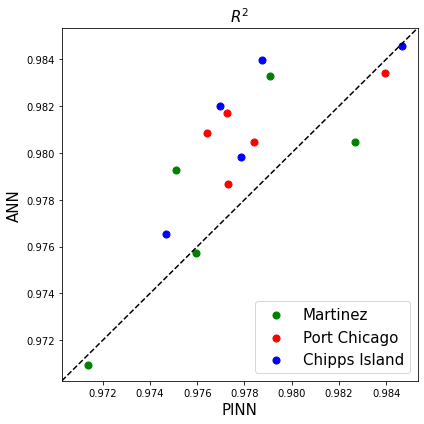

In [ ]:
## R^2
f, ax = pl.subplots(figsize=(6, 6))

ax.scatter(RESULTS1['Martinez']['PINN_results']['R'], RESULTS1['Martinez']['ANN_results']['R'], s=50, c='g', label='Martinez')
ax.scatter(RESULTS2['Martinez']['PINN_results']['R'], RESULTS2['Martinez']['ANN_results']['R'], s=50, c='g')
ax.scatter(RESULTS3['Martinez']['PINN_results']['R'], RESULTS3['Martinez']['ANN_results']['R'], s=50, c='g')
ax.scatter(RESULTS4['Martinez']['PINN_results']['R'], RESULTS4['Martinez']['ANN_results']['R'], s=50, c='g')
ax.scatter(RESULTS5['Martinez']['PINN_results']['R'], RESULTS5['Martinez']['ANN_results']['R'], s=50, c='g')

ax.scatter(RESULTS1['Port Chicago']['PINN_results']['R'], RESULTS1['Port Chicago']['ANN_results']['R'], s=50, c='r', label='Port Chicago')
ax.scatter(RESULTS2['Port Chicago']['PINN_results']['R'], RESULTS2['Port Chicago']['ANN_results']['R'], s=50, c='r')
ax.scatter(RESULTS3['Port Chicago']['PINN_results']['R'], RESULTS3['Port Chicago']['ANN_results']['R'], s=50, c='r')
ax.scatter(RESULTS4['Port Chicago']['PINN_results']['R'], RESULTS4['Port Chicago']['ANN_results']['R'], s=50, c='r')
ax.scatter(RESULTS5['Port Chicago']['PINN_results']['R'], RESULTS5['Port Chicago']['ANN_results']['R'], s=50, c='r')

ax.scatter(RESULTS1['Chipps Island']['PINN_results']['R'], RESULTS1['Chipps Island']['ANN_results']['R'], s=50, c='b', label='Chipps Island')
ax.scatter(RESULTS2['Chipps Island']['PINN_results']['R'], RESULTS2['Chipps Island']['ANN_results']['R'], s=50, c='b')
ax.scatter(RESULTS3['Chipps Island']['PINN_results']['R'], RESULTS3['Chipps Island']['ANN_results']['R'], s=50, c='b')
ax.scatter(RESULTS4['Chipps Island']['PINN_results']['R'], RESULTS4['Chipps Island']['ANN_results']['R'], s=50, c='b')
ax.scatter(RESULTS5['Chipps Island']['PINN_results']['R'], RESULTS5['Chipps Island']['ANN_results']['R'], s=50, c='b')

lower, upper = min(min(ax.get_xlim()), min(ax.get_ylim())), max(max(ax.get_xlim()), max(ax.get_ylim()))
ax.set(xlim=(lower, upper), ylim=(lower, upper))
add_identity(ax, color='k', ls='--')

pl.title('$R^2$', fontsize=15)
pl.xlabel('PINN', fontsize=15)
pl.ylabel('ANN', fontsize=15)
pl.legend(fontsize=15)
pl.tight_layout()

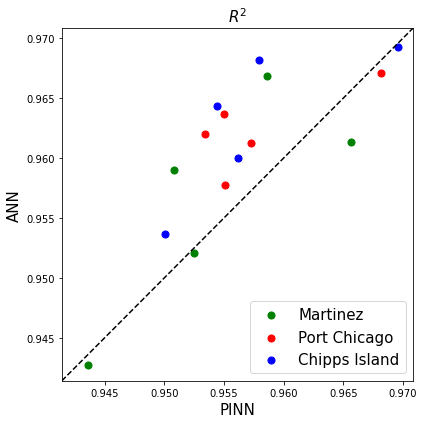

In [ ]:
## R^2
f, ax = pl.subplots(figsize=(6, 6))

ax.scatter(RESULTS1['Martinez']['PINN_results']['R']**2, RESULTS1['Martinez']['ANN_results']['R']**2, s=50, c='g', label='Martinez')
ax.scatter(RESULTS2['Martinez']['PINN_results']['R']**2, RESULTS2['Martinez']['ANN_results']['R']**2, s=50, c='g')
ax.scatter(RESULTS3['Martinez']['PINN_results']['R']**2, RESULTS3['Martinez']['ANN_results']['R']**2, s=50, c='g')
ax.scatter(RESULTS4['Martinez']['PINN_results']['R']**2, RESULTS4['Martinez']['ANN_results']['R']**2, s=50, c='g')
ax.scatter(RESULTS5['Martinez']['PINN_results']['R']**2, RESULTS5['Martinez']['ANN_results']['R']**2, s=50, c='g')

ax.scatter(RESULTS1['Port Chicago']['PINN_results']['R']**2, RESULTS1['Port Chicago']['ANN_results']['R']**2, s=50, c='r', label='Port Chicago')
ax.scatter(RESULTS2['Port Chicago']['PINN_results']['R']**2, RESULTS2['Port Chicago']['ANN_results']['R']**2, s=50, c='r')
ax.scatter(RESULTS3['Port Chicago']['PINN_results']['R']**2, RESULTS3['Port Chicago']['ANN_results']['R']**2, s=50, c='r')
ax.scatter(RESULTS4['Port Chicago']['PINN_results']['R']**2, RESULTS4['Port Chicago']['ANN_results']['R']**2, s=50, c='r')
ax.scatter(RESULTS5['Port Chicago']['PINN_results']['R']**2, RESULTS5['Port Chicago']['ANN_results']['R']**2, s=50, c='r')

ax.scatter(RESULTS1['Chipps Island']['PINN_results']['R']**2, RESULTS1['Chipps Island']['ANN_results']['R']**2, s=50, c='b', label='Chipps Island')
ax.scatter(RESULTS2['Chipps Island']['PINN_results']['R']**2, RESULTS2['Chipps Island']['ANN_results']['R']**2, s=50, c='b')
ax.scatter(RESULTS3['Chipps Island']['PINN_results']['R']**2, RESULTS3['Chipps Island']['ANN_results']['R']**2, s=50, c='b')
ax.scatter(RESULTS4['Chipps Island']['PINN_results']['R']**2, RESULTS4['Chipps Island']['ANN_results']['R']**2, s=50, c='b')
ax.scatter(RESULTS5['Chipps Island']['PINN_results']['R']**2, RESULTS5['Chipps Island']['ANN_results']['R']**2, s=50, c='b')

lower, upper = min(min(ax.get_xlim()), min(ax.get_ylim())), max(max(ax.get_xlim()), max(ax.get_ylim()))
ax.set(xlim=(lower, upper), ylim=(lower, upper))
add_identity(ax, color='k', ls='--')

pl.title('$R^2$', fontsize=15)
pl.xlabel('PINN', fontsize=15)
pl.ylabel('ANN', fontsize=15)
pl.legend(fontsize=15)
pl.tight_layout()

In [ ]:
## Save plots

fig_savepath = os.path.join(gdrive_root_path, "images/5-fold", "R^2" + "M+P+C_test (Best)")
f.savefig(fig_savepath, bbox_inches='tight',dpi=300)

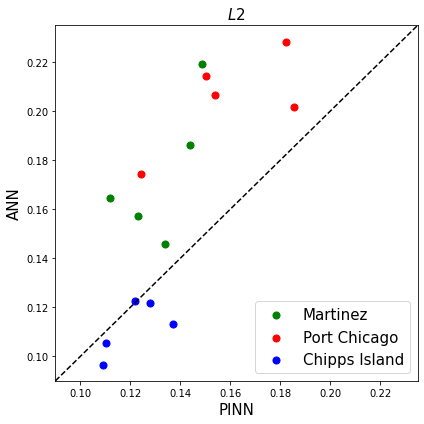

In [ ]:
## L2
f, ax = pl.subplots(figsize=(6, 6))

metric = 'L2'

ax.scatter(RESULTS1['Martinez']['PINN_results'][metric], RESULTS1['Martinez']['ANN_results'][metric], s=50, c='g', label='Martinez')
ax.scatter(RESULTS2['Martinez']['PINN_results'][metric], RESULTS2['Martinez']['ANN_results'][metric], s=50, c='g')
ax.scatter(RESULTS3['Martinez']['PINN_results'][metric], RESULTS3['Martinez']['ANN_results'][metric], s=50, c='g')
ax.scatter(RESULTS4['Martinez']['PINN_results'][metric], RESULTS4['Martinez']['ANN_results'][metric], s=50, c='g')
ax.scatter(RESULTS5['Martinez']['PINN_results'][metric], RESULTS5['Martinez']['ANN_results'][metric], s=50, c='g')

ax.scatter(RESULTS1['Port Chicago']['PINN_results'][metric], RESULTS1['Port Chicago']['ANN_results'][metric], s=50, c='r', label='Port Chicago')
ax.scatter(RESULTS2['Port Chicago']['PINN_results'][metric], RESULTS2['Port Chicago']['ANN_results'][metric], s=50, c='r')
ax.scatter(RESULTS3['Port Chicago']['PINN_results'][metric], RESULTS3['Port Chicago']['ANN_results'][metric], s=50, c='r')
ax.scatter(RESULTS4['Port Chicago']['PINN_results'][metric], RESULTS4['Port Chicago']['ANN_results'][metric], s=50, c='r')
ax.scatter(RESULTS5['Port Chicago']['PINN_results'][metric], RESULTS5['Port Chicago']['ANN_results'][metric], s=50, c='r')

ax.scatter(RESULTS1['Chipps Island']['PINN_results'][metric], RESULTS1['Chipps Island']['ANN_results'][metric], s=50, c='b', label='Chipps Island')
ax.scatter(RESULTS2['Chipps Island']['PINN_results'][metric], RESULTS2['Chipps Island']['ANN_results'][metric], s=50, c='b')
ax.scatter(RESULTS3['Chipps Island']['PINN_results'][metric], RESULTS3['Chipps Island']['ANN_results'][metric], s=50, c='b')
ax.scatter(RESULTS4['Chipps Island']['PINN_results'][metric], RESULTS4['Chipps Island']['ANN_results'][metric], s=50, c='b')
ax.scatter(RESULTS5['Chipps Island']['PINN_results'][metric], RESULTS5['Chipps Island']['ANN_results'][metric], s=50, c='b')

lower, upper = min(min(ax.get_xlim()), min(ax.get_ylim())), max(max(ax.get_xlim()), max(ax.get_ylim()))
ax.set(xlim=(lower, upper), ylim=(lower, upper))
add_identity(ax, color='k', ls='--')

pl.title('$L2$', fontsize=15)
pl.xlabel('PINN', fontsize=15)
pl.ylabel('ANN', fontsize=15)
pl.legend(fontsize=15)
pl.tight_layout()

In [ ]:
## Save plots

fig_savepath = os.path.join(gdrive_root_path, "images/5-fold", "L2" + "M+P+C_test (Best)")
f.savefig(fig_savepath, bbox_inches='tight',dpi=300)

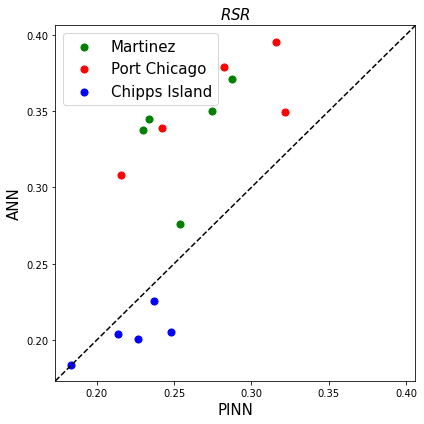

In [ ]:
## RSR
f, ax = pl.subplots(figsize=(6, 6))

metric = 'RSR'

ax.scatter(RESULTS1['Martinez']['PINN_results'][metric], RESULTS1['Martinez']['ANN_results'][metric], s=50, c='g', label='Martinez')
ax.scatter(RESULTS2['Martinez']['PINN_results'][metric], RESULTS2['Martinez']['ANN_results'][metric], s=50, c='g')
ax.scatter(RESULTS3['Martinez']['PINN_results'][metric], RESULTS3['Martinez']['ANN_results'][metric], s=50, c='g')
ax.scatter(RESULTS4['Martinez']['PINN_results'][metric], RESULTS4['Martinez']['ANN_results'][metric], s=50, c='g')
ax.scatter(RESULTS5['Martinez']['PINN_results'][metric], RESULTS5['Martinez']['ANN_results'][metric], s=50, c='g')

ax.scatter(RESULTS1['Port Chicago']['PINN_results'][metric], RESULTS1['Port Chicago']['ANN_results'][metric], s=50, c='r', label='Port Chicago')
ax.scatter(RESULTS2['Port Chicago']['PINN_results'][metric], RESULTS2['Port Chicago']['ANN_results'][metric], s=50, c='r')
ax.scatter(RESULTS3['Port Chicago']['PINN_results'][metric], RESULTS3['Port Chicago']['ANN_results'][metric], s=50, c='r')
ax.scatter(RESULTS4['Port Chicago']['PINN_results'][metric], RESULTS4['Port Chicago']['ANN_results'][metric], s=50, c='r')
ax.scatter(RESULTS5['Port Chicago']['PINN_results'][metric], RESULTS5['Port Chicago']['ANN_results'][metric], s=50, c='r')

ax.scatter(RESULTS1['Chipps Island']['PINN_results'][metric], RESULTS1['Chipps Island']['ANN_results'][metric], s=50, c='b', label='Chipps Island')
ax.scatter(RESULTS2['Chipps Island']['PINN_results'][metric], RESULTS2['Chipps Island']['ANN_results'][metric], s=50, c='b')
ax.scatter(RESULTS3['Chipps Island']['PINN_results'][metric], RESULTS3['Chipps Island']['ANN_results'][metric], s=50, c='b')
ax.scatter(RESULTS4['Chipps Island']['PINN_results'][metric], RESULTS4['Chipps Island']['ANN_results'][metric], s=50, c='b')
ax.scatter(RESULTS5['Chipps Island']['PINN_results'][metric], RESULTS5['Chipps Island']['ANN_results'][metric], s=50, c='b')

lower, upper = min(min(ax.get_xlim()), min(ax.get_ylim())), max(max(ax.get_xlim()), max(ax.get_ylim()))
ax.set(xlim=(lower, upper), ylim=(lower, upper))
add_identity(ax, color='k', ls='--')

pl.title('$RSR$', fontsize=15)
pl.xlabel('PINN', fontsize=15)
pl.ylabel('ANN', fontsize=15)
pl.legend(fontsize=15)
pl.tight_layout()

In [ ]:
## Save plots

fig_savepath = os.path.join(gdrive_root_path, "images/5-fold", "RSR" + "M+P+C_test (Best)")
f.savefig(fig_savepath, bbox_inches='tight',dpi=300)

## Time series plots for test set

In [ ]:
def plotter(k, RESULTS, xloc, yloc, tst_years):
    """
    Plots and returns PINN and ANN time series plots at three locations for kth fold

    PARAMETERS
    ----------
    k:          int
                kth fold
    RESULTS:    Hash Table
                contains evaluation metrics
    xloc:       int
                x-axis location on plot for evaluation metrics
    yloc:       int
                y-axis location on plot for evaluation metrics
    tst_years:  str list
                testing years
    RETURNS
    -------
    fig1:       matplotlib plot
                time seris of DSM2, PINN, ANN at Martinez
    fig2:       matplotlib plot
                time seris of DSM2, PINN, ANN at Port Chicago
    fig3:       matplotlib plot
                time seris of DSM2, PINN, ANN at Chipps Island
    """

    tst_EC_d = DATA_SET[k]['tst_EC_d']

    PINN_timeseries_M = RESULTS['Martinez']['PINN_timeseries']
    ANN_timeseries_M = RESULTS['Martinez']['ANN_timeseries']
    PINN_results_M = RESULTS['Martinez']['PINN_results']
    ANN_results_M = RESULTS['Martinez']['ANN_results']

    PINN_timeseries_P = RESULTS['Port Chicago']['PINN_timeseries']
    ANN_timeseries_P = RESULTS['Port Chicago']['ANN_timeseries']
    PINN_results_P = RESULTS['Port Chicago']['PINN_results']
    ANN_results_P = RESULTS['Port Chicago']['ANN_results']

    PINN_timeseries_C = RESULTS['Chipps Island']['PINN_timeseries']
    ANN_timeseries_C = RESULTS['Chipps Island']['ANN_timeseries']
    PINN_results_C = RESULTS['Chipps Island']['PINN_results']
    ANN_results_C = RESULTS['Chipps Island']['ANN_results']

    ## At Martinez
    fig1 = pl.figure(1, figsize=(24,6))
    pl.plot(tst_EC_d[:, 0] * (EC_max - EC_min) + EC_min, marker='.', linestyle='dashed', label='DSM2:daily')
    pl.plot(PINN_timeseries_M* (EC_max - EC_min) + EC_min, marker='.', linestyle='dashed', label='PINN')
    pl.plot(ANN_timeseries_M * (EC_max - EC_min) + EC_min, marker='.', linestyle='dashed', label='ANN')
    pl.text(xloc, yloc, '          PINN       ANN\nBias | %.3f   %.3f\nNSE | %.3f    %.3f\n$R^2$    | %.3f    %.3f' % (PINN_results_M['Bias'], ANN_results_M['Bias'], PINN_results_M['NSE'], ANN_results_M['NSE'], PINN_results_M['R']**2, ANN_results_M['R']**2), fontsize=20)
    pl.legend(loc='upper left', fontsize=20)
    pl.xticks(np.arange(182.5, len(tst_EC_d), step=365), tst_years, fontsize=20)
    pl.ylabel('EC', fontsize=20)
    pl.title('Martinez (%s-%s)' % (tst_years[0], tst_years[-1]), fontsize=20)
    pl.tight_layout()

    ## At Port Chicago
    fig2 = pl.figure(2, figsize=(24,6))
    pl.plot(tst_EC_d[:, 1] * (EC_max - EC_min) + EC_min, marker='.', linestyle='dashed', label='DSM2:daily')
    pl.plot(PINN_timeseries_P * (EC_max - EC_min) + EC_min, marker='.', linestyle='dashed', label='PINN')
    pl.plot(ANN_timeseries_P * (EC_max - EC_min) + EC_min, marker='.', linestyle='dashed', label='ANN')
    pl.text(xloc, yloc, '          PINN       ANN\nBias | %.3f   %.3f\nNSE | %.3f    %.3f\n$R^2$    | %.3f    %.3f' % (PINN_results_P['Bias'], ANN_results_P['Bias'], PINN_results_P['NSE'], ANN_results_P['NSE'], PINN_results_P['R']**2, ANN_results_P['R']**2), fontsize=20)
    pl.legend(loc='upper left', fontsize=20)
    pl.xticks(np.arange(182.5, len(tst_EC_d), step=365), tst_years, fontsize=20)
    pl.ylabel('EC', fontsize=20)
    pl.title('Port Chicago (%s-%s)' % (tst_years[0], tst_years[-1]), fontsize=20)
    pl.tight_layout()

    ## At Chipps Island
    fig3 = pl.figure(3, figsize=(24,6))
    pl.plot(tst_EC_d[:, 2] * (EC_max - EC_min) + EC_min, marker='.', linestyle='dashed', label='DSM2:daily')
    pl.plot(PINN_timeseries_C * (EC_max - EC_min) + EC_min, marker='.', linestyle='dashed', label='PINN')
    pl.plot(ANN_timeseries_C * (EC_max - EC_min) + EC_min, marker='.', linestyle='dashed', label='ANN')
    pl.text(xloc, yloc, '          PINN       ANN\nBias | %.3f    %.3f\nNSE | %.3f    %.3f\n$R^2$    | %.3f    %.3f' % (PINN_results_C['Bias'], ANN_results_C['Bias'], PINN_results_C['NSE'], ANN_results_C['NSE'], PINN_results_C['R']**2, ANN_results_C['R']**2), fontsize=20)
    pl.legend(loc='upper left', fontsize=20)
    pl.xticks(np.arange(182.5, len(tst_EC_d), step=365), tst_years, fontsize=20)
    pl.ylabel('EC', fontsize=20)
    pl.title('Chipps Island (%s-%s)' % (tst_years[0], tst_years[-1]), fontsize=20)
    pl.tight_layout()

    return fig1, fig2, fig3

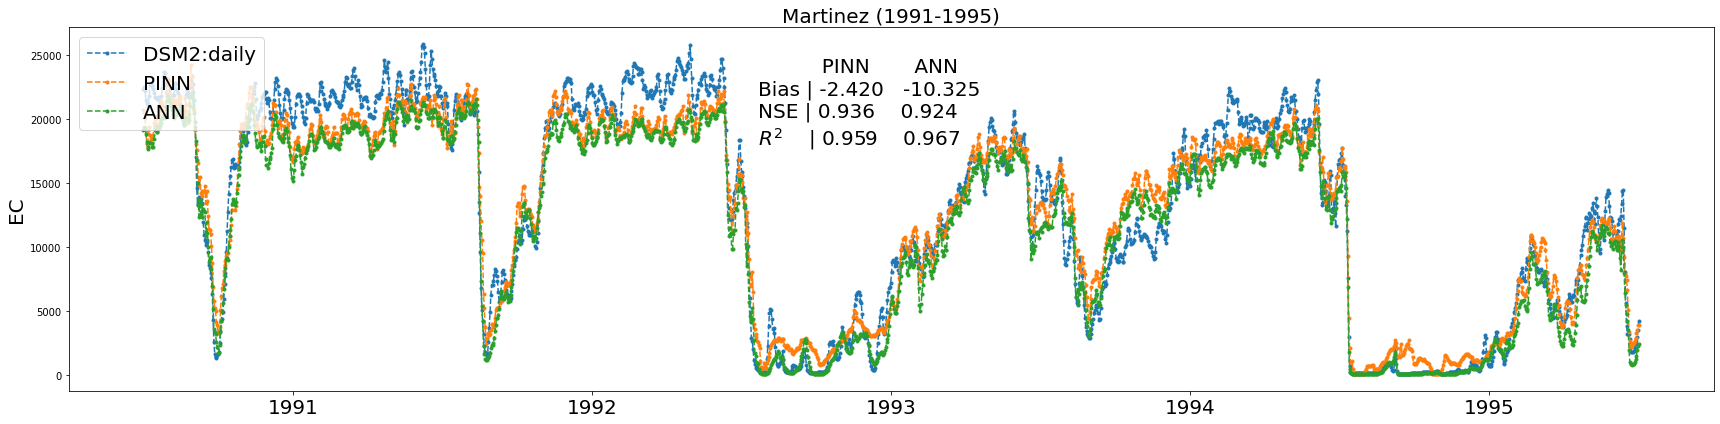

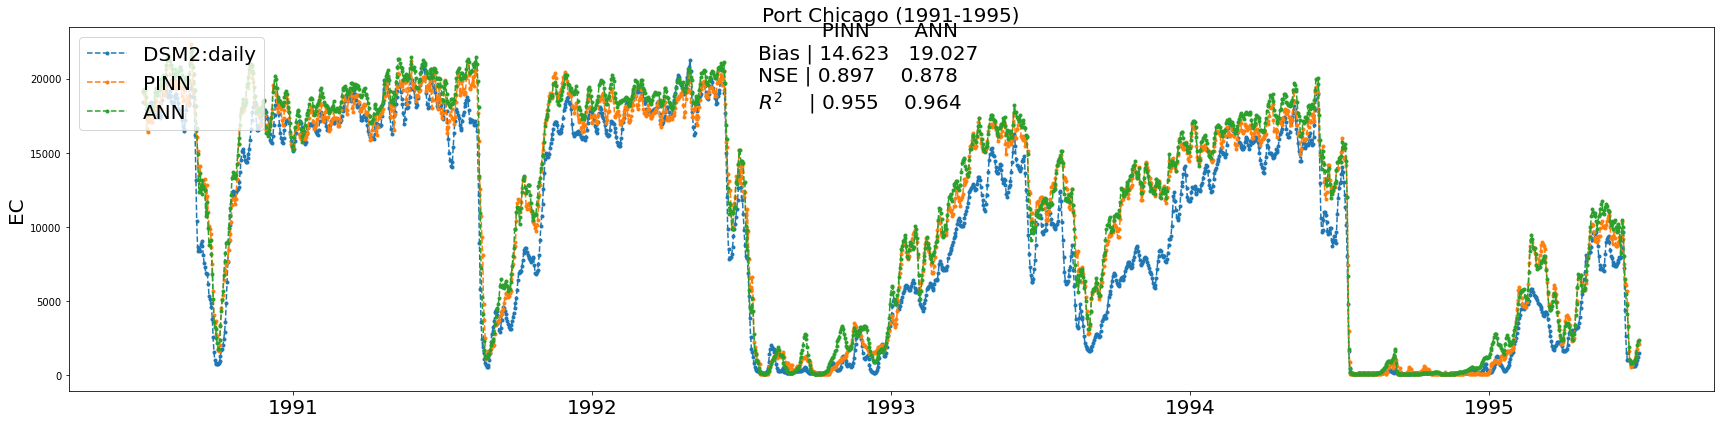

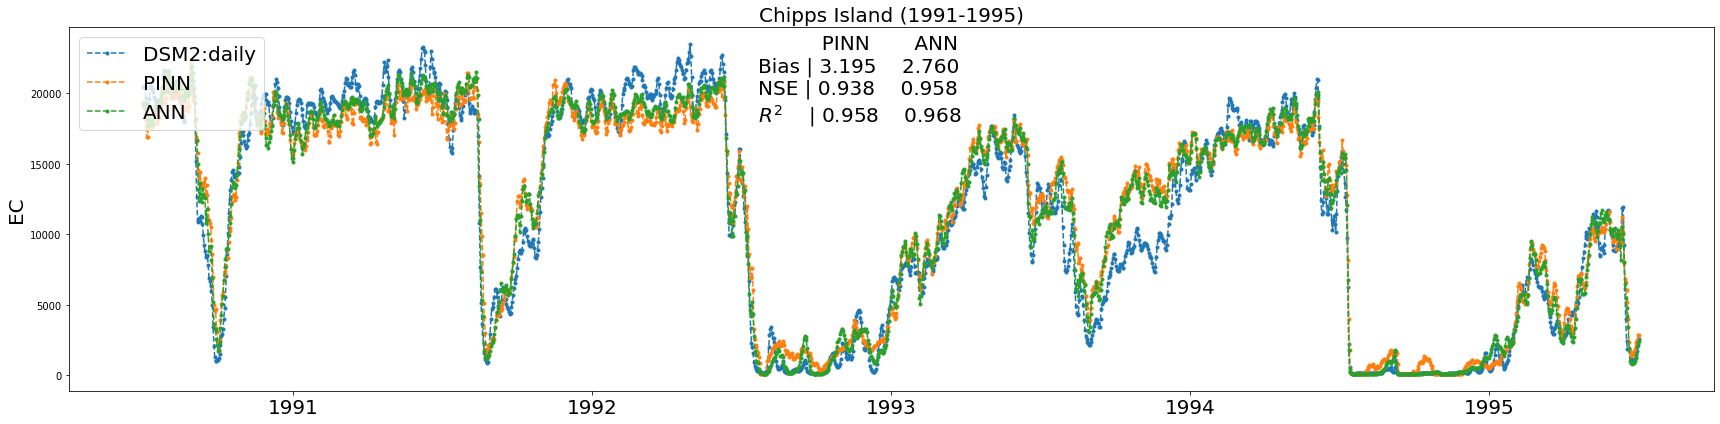

In [ ]:
fig1, fig2, fig3 = plotter(1, RESULTS1, 750, 18000, ['1991','1992','1993','1994','1995'])

In [ ]:
kfold = "first"

fig_savepath = os.path.join(gdrive_root_path, "images/5-fold", kfold + "_Martinez_test (Best)")
fig1.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/5-fold", kfold + "_Port Chicago_test (Best)")
fig2.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/5-fold", kfold + "_Chipps Island_test (Best")
fig3.savefig(fig_savepath, bbox_inches='tight',dpi=300)

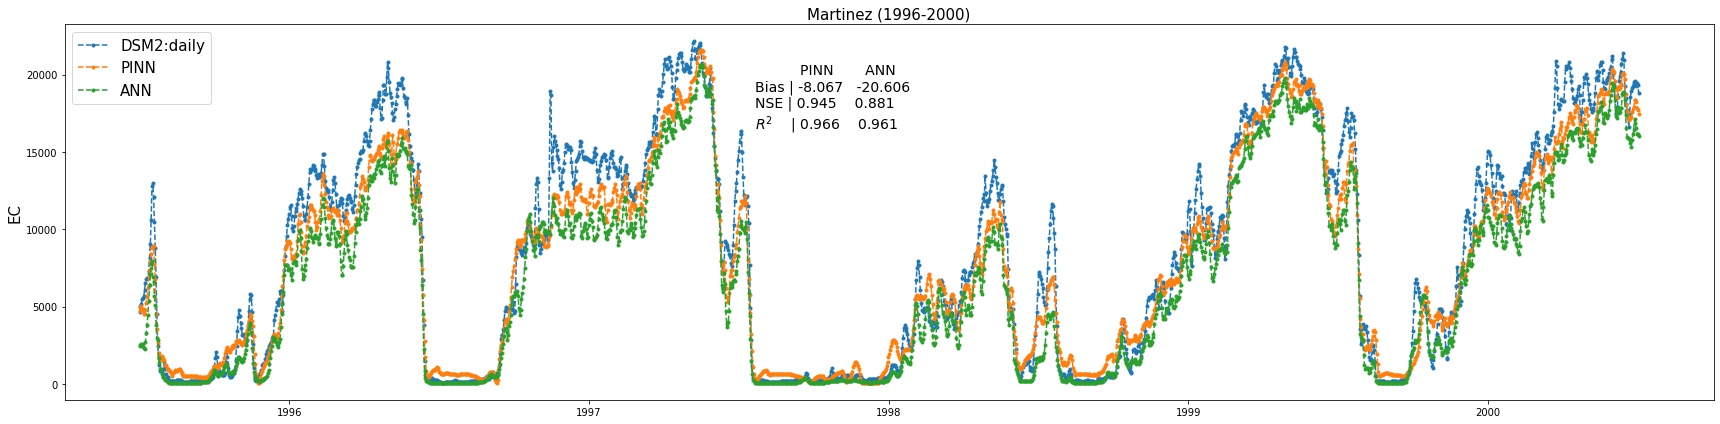

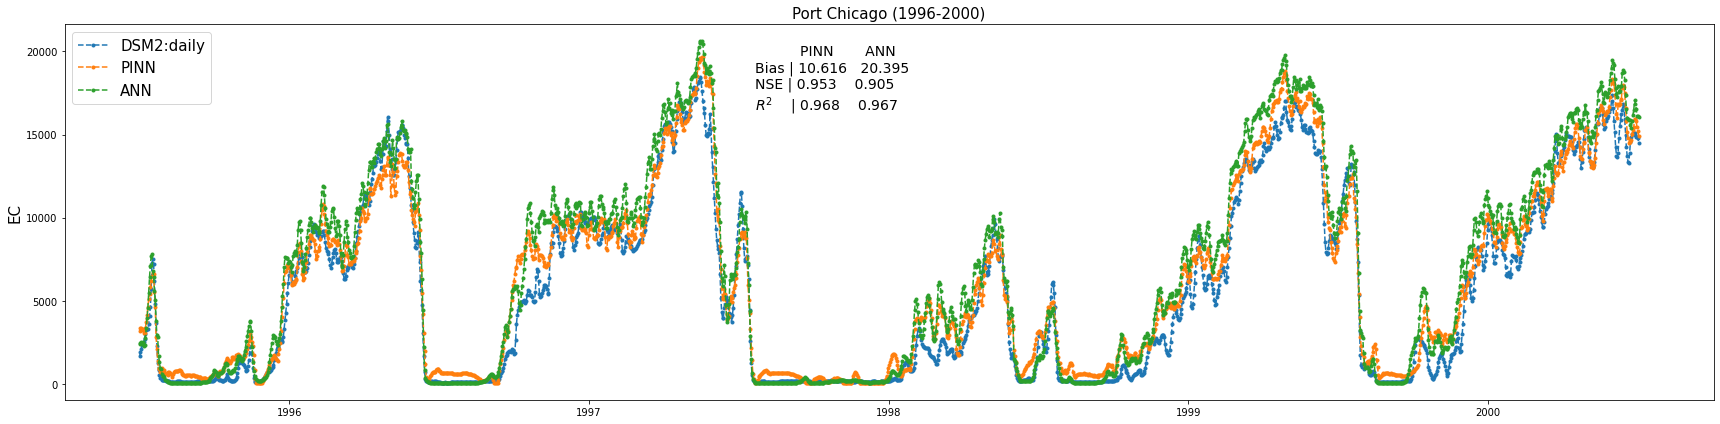

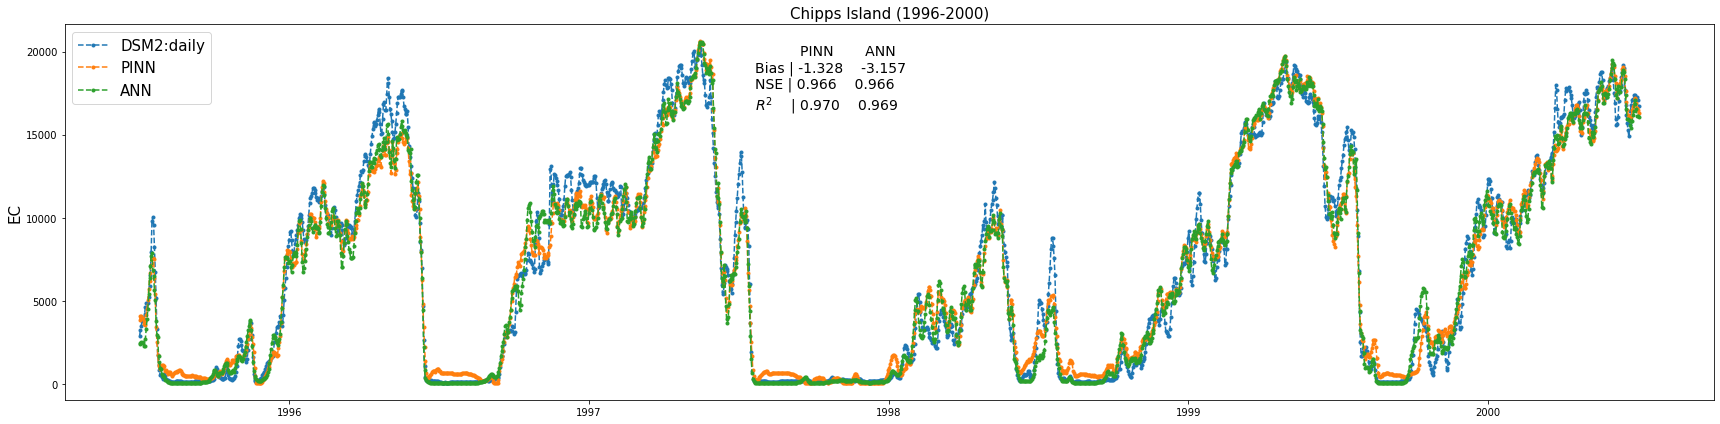

In [ ]:
fig1, fig2, fig3 = plotter(2, RESULTS2, 750, 16500, ['1996','1997','1998','1999','2000'])

In [ ]:
kfold = "second"

fig_savepath = os.path.join(gdrive_root_path, "images/5-fold", kfold + "_Martinez_test (Best)")
fig1.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/5-fold", kfold + "_Port Chicago_test (Best)")
fig2.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/5-fold", kfold + "_Chipps Island_test (Best")
fig3.savefig(fig_savepath, bbox_inches='tight',dpi=300)

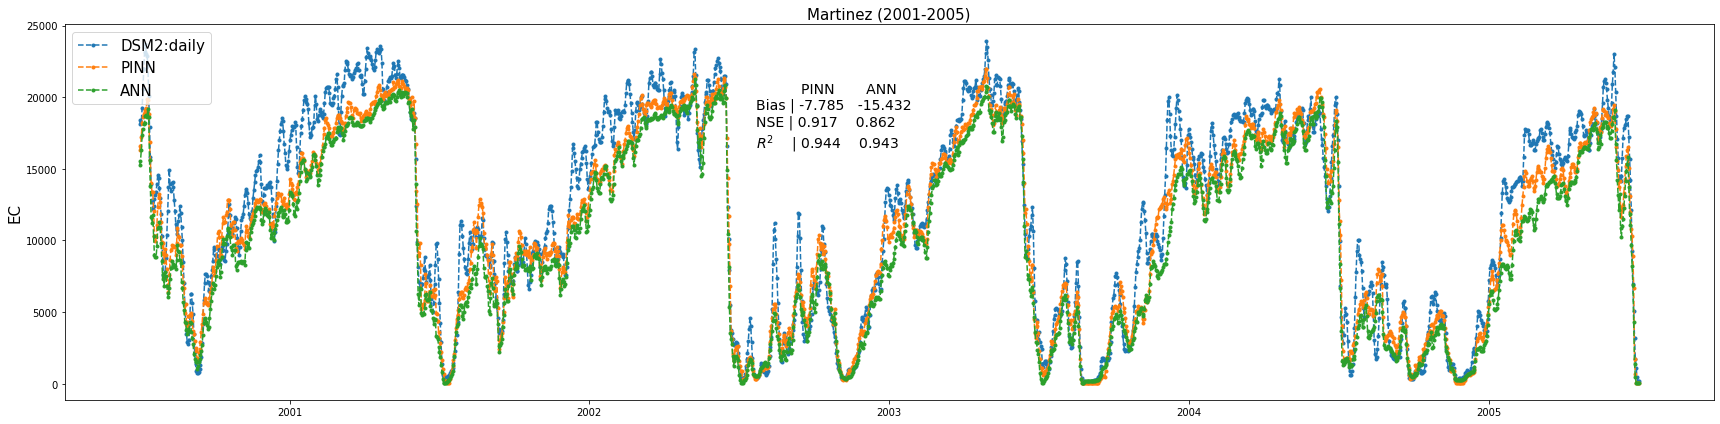

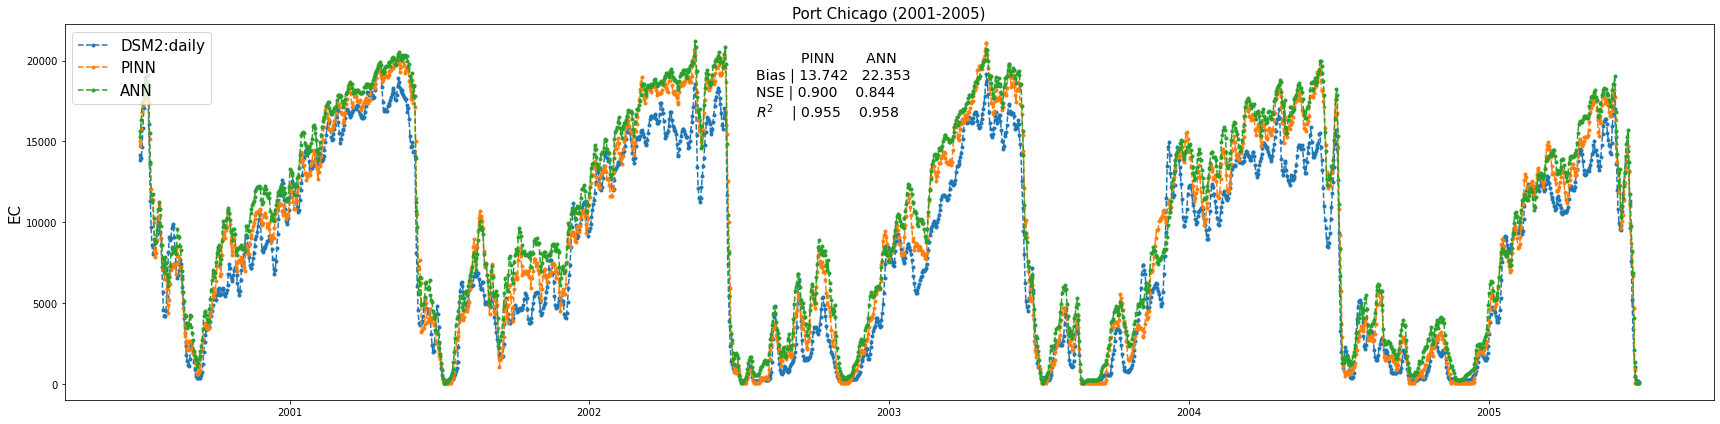

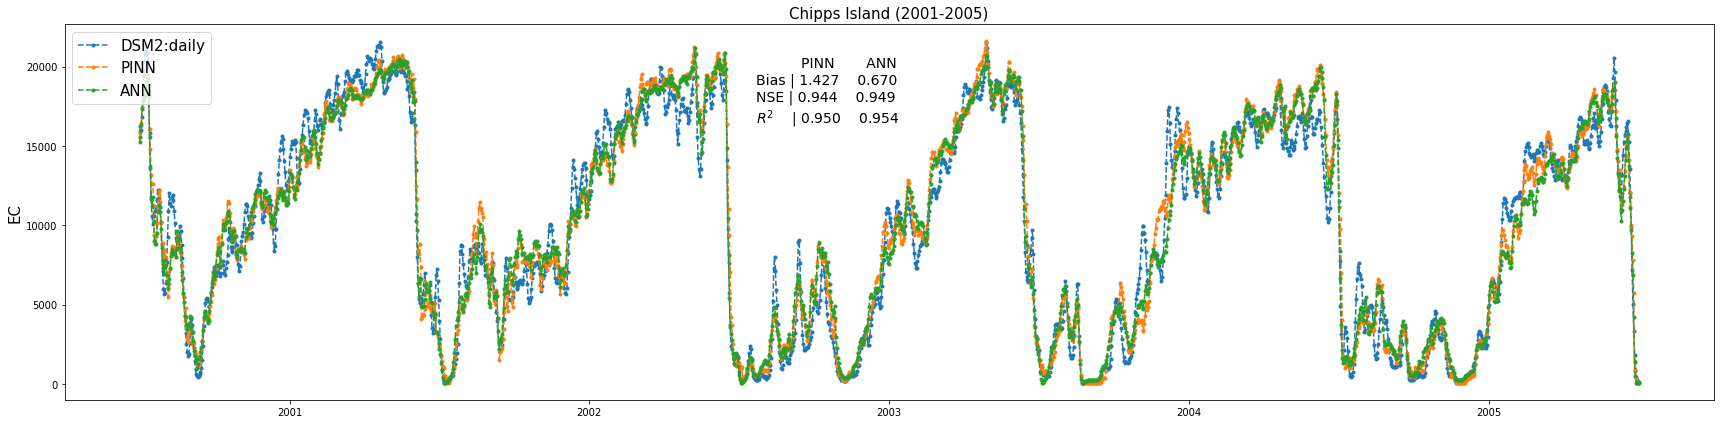

In [ ]:
fig1, fig2, fig3 = plotter(3, RESULTS3, 750, 16500, ['2001','2002','2003','2004','2005'])

In [ ]:
kfold = "third"

fig_savepath = os.path.join(gdrive_root_path, "images/5-fold", kfold + "_Martinez_test (Best)")
fig1.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/5-fold", kfold + "_Port Chicago_test (Best)")
fig2.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/5-fold", kfold + "_Chipps Island_test (Best")
fig3.savefig(fig_savepath, bbox_inches='tight',dpi=300)

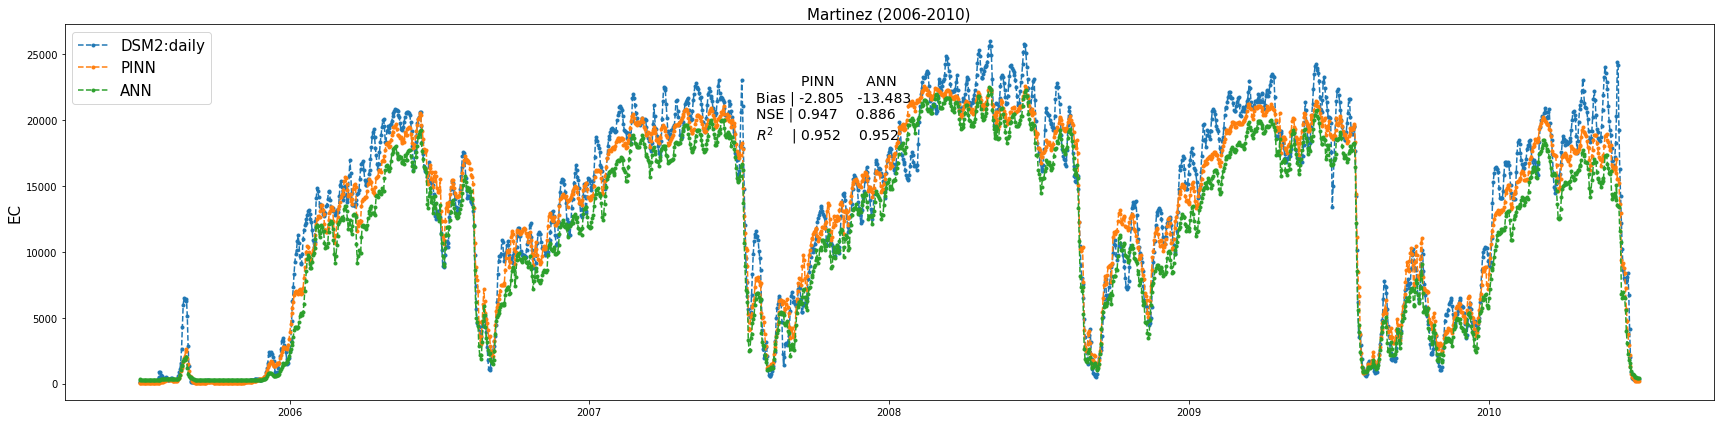

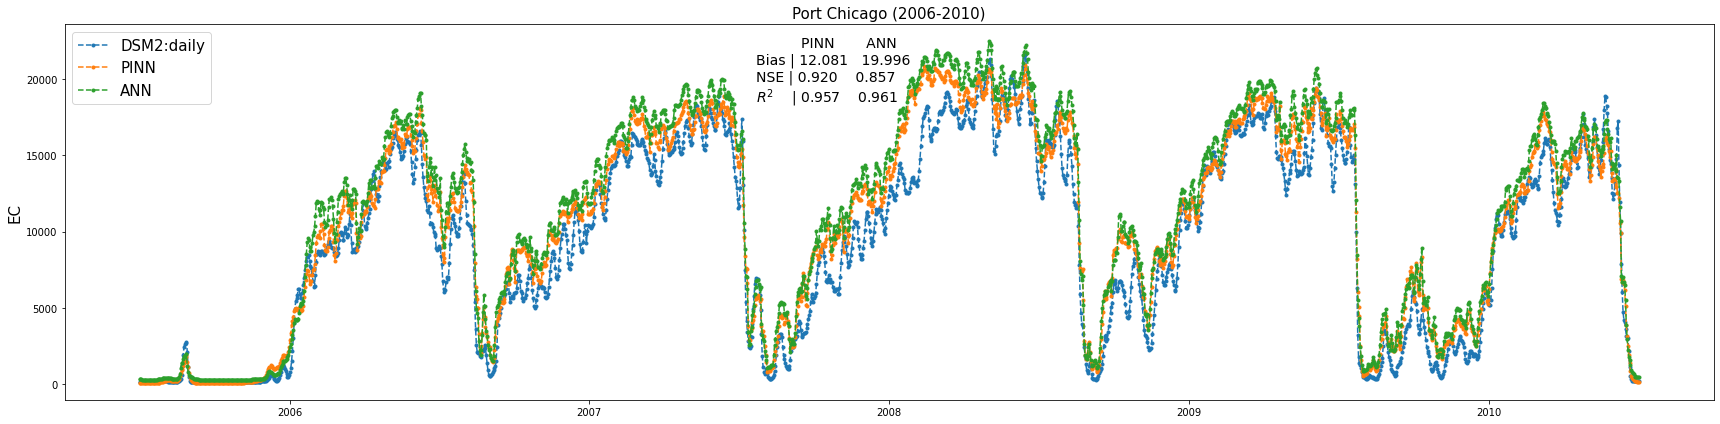

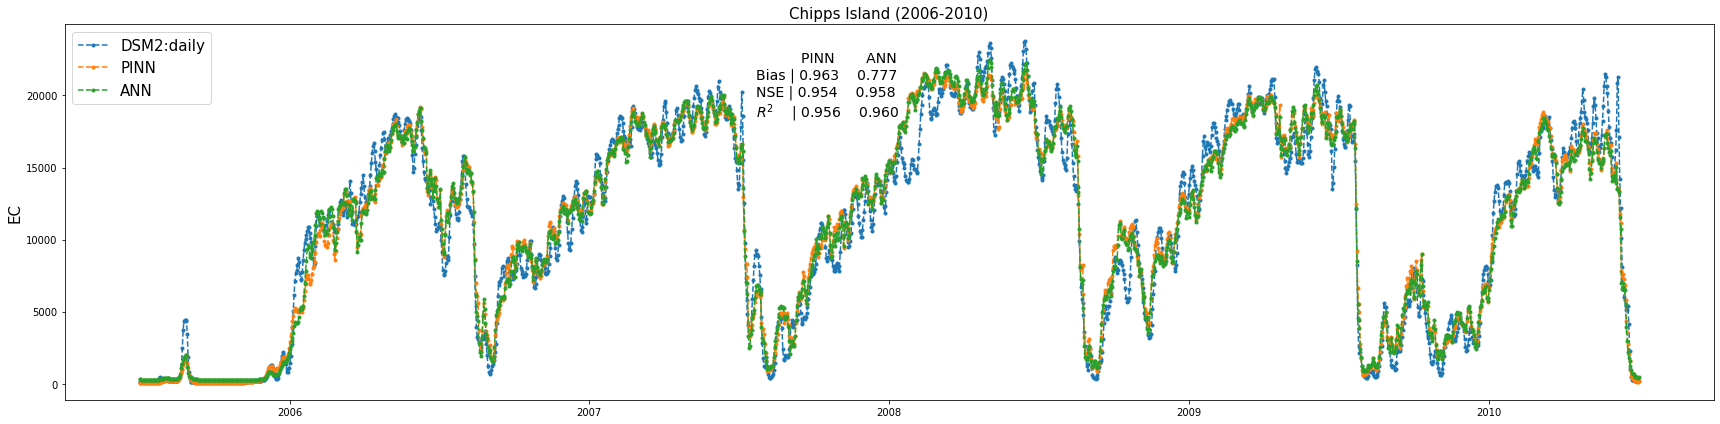

In [ ]:
fig1, fig2, fig3 = plotter(4, RESULTS4, 750, 18500, ['2006','2007','2008','2009','2010'])

In [ ]:
kfold = "fourth"

fig_savepath = os.path.join(gdrive_root_path, "images/5-fold", kfold + "_Martinez_test (Best)")
fig1.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/5-fold", kfold + "_Port Chicago_test (Best)")
fig2.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/5-fold", kfold + "_Chipps Island_test (Best")
fig3.savefig(fig_savepath, bbox_inches='tight',dpi=300)

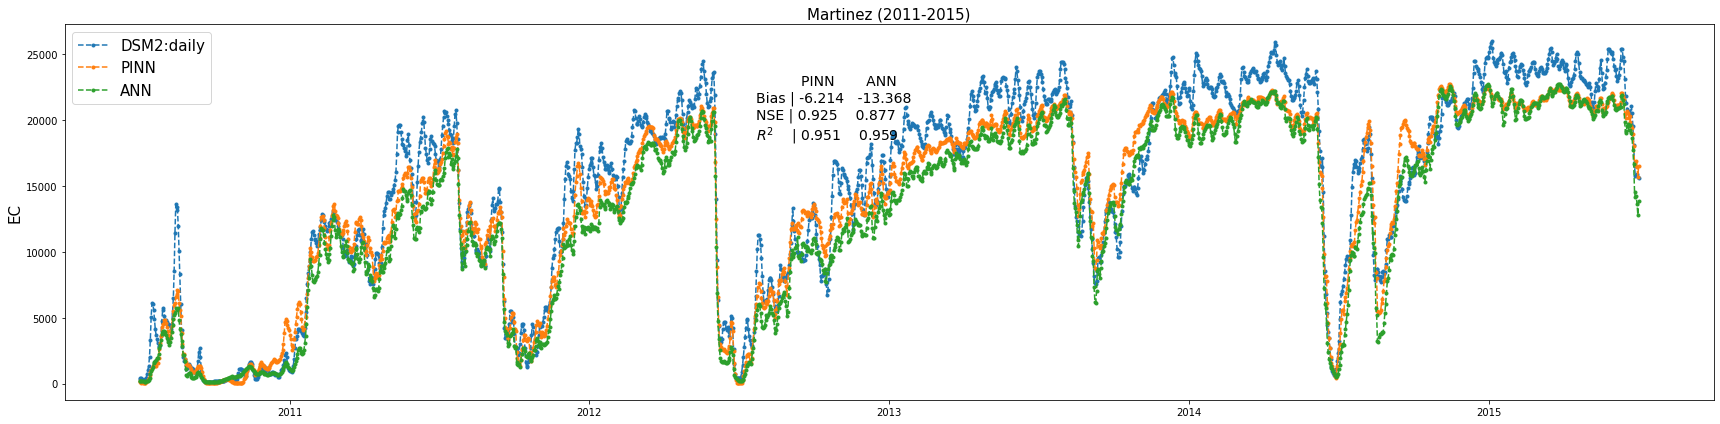

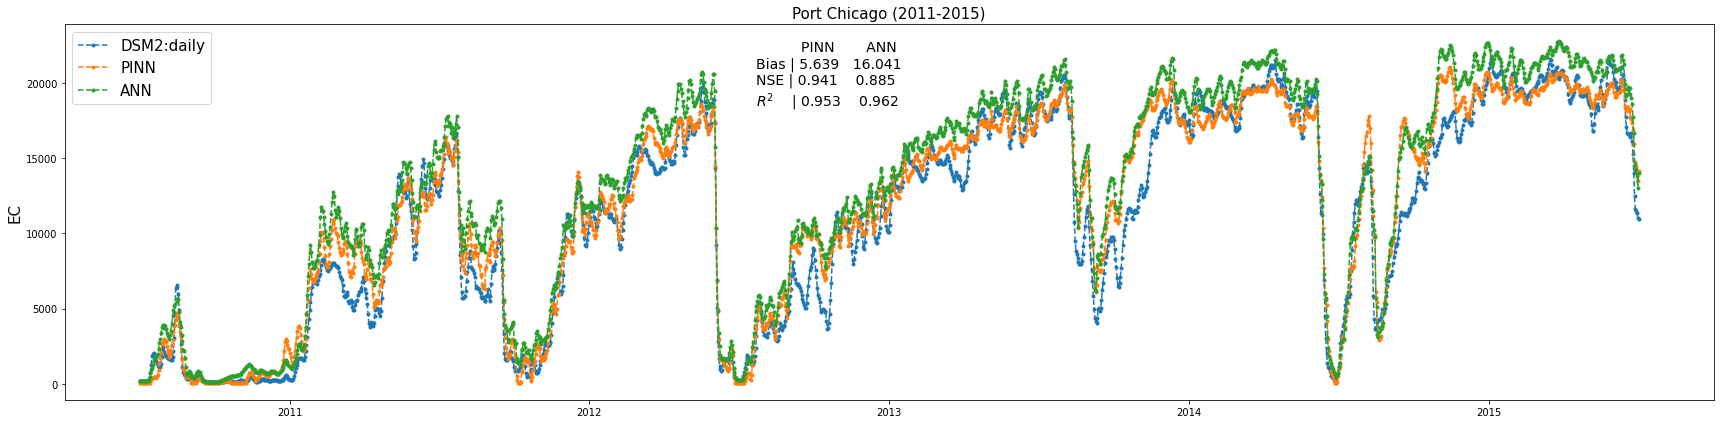

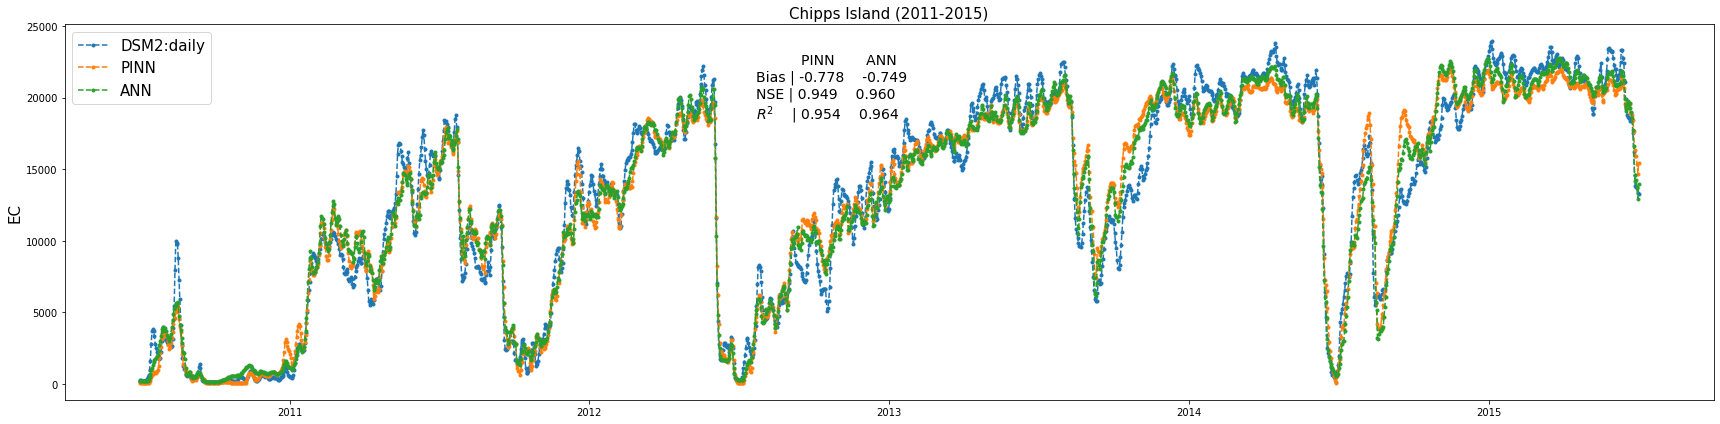

In [ ]:
fig1, fig2, fig3 = plotter(5, RESULTS5, 750, 18500, ['2011','2012','2013','2014','2015'])

In [ ]:
kfold = "fifth"

fig_savepath = os.path.join(gdrive_root_path, "images/5-fold", kfold + "_Martinez_test (Best)")
fig1.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/5-fold", kfold + "_Port Chicago_test (Best)")
fig2.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/5-fold", kfold + "_Chipps Island_test (Best")
fig3.savefig(fig_savepath, bbox_inches='tight',dpi=300)

## Without R^2

In [ ]:
def plotter2(k, RESULTS, xloc, yloc, tst_years):
    """
    Plots and returns PINN and ANN time series plots at three locations for kth fold

    PARAMETERS
    ----------
    k:          int
                kth fold
    RESULTS:    Hash Table
                contains evaluation metrics
    xloc:       int
                x-axis location on plot for evaluation metrics
    yloc:       int
                y-axis location on plot for evaluation metrics
    tst_years:  str list
                testing years
    RETURNS
    -------
    fig1:       matplotlib plot
                time seris of DSM2, PINN, ANN at Martinez
    fig2:       matplotlib plot
                time seris of DSM2, PINN, ANN at Port Chicago
    fig3:       matplotlib plot
                time seris of DSM2, PINN, ANN at Chipps Island
    """

    tst_EC_d = DATA_SET[k]['tst_EC_d']

    PINN_timeseries_M = RESULTS['Martinez']['PINN_timeseries']
    ANN_timeseries_M = RESULTS['Martinez']['ANN_timeseries']
    PINN_results_M = RESULTS['Martinez']['PINN_results']
    ANN_results_M = RESULTS['Martinez']['ANN_results']

    PINN_timeseries_P = RESULTS['Port Chicago']['PINN_timeseries']
    ANN_timeseries_P = RESULTS['Port Chicago']['ANN_timeseries']
    PINN_results_P = RESULTS['Port Chicago']['PINN_results']
    ANN_results_P = RESULTS['Port Chicago']['ANN_results']

    PINN_timeseries_C = RESULTS['Chipps Island']['PINN_timeseries']
    ANN_timeseries_C = RESULTS['Chipps Island']['ANN_timeseries']
    PINN_results_C = RESULTS['Chipps Island']['PINN_results']
    ANN_results_C = RESULTS['Chipps Island']['ANN_results']

    ## At Martinez
    fig1 = pl.figure(1, figsize=(24,6))
    pl.plot(tst_EC_d[:, 0] * (EC_max - EC_min) + EC_min, marker='.', linestyle='dashed', label='DSM2:daily')
    pl.plot(PINN_timeseries_M* (EC_max - EC_min) + EC_min, marker='.', linestyle='dashed', label='PINN')
    pl.plot(ANN_timeseries_M * (EC_max - EC_min) + EC_min, marker='.', linestyle='dashed', label='ANN')
    pl.text(xloc, yloc, '          PINN       ANN\nBias | %.3f   %.3f\nNSE | %.3f    %.3f' % (PINN_results_M['Bias'], ANN_results_M['Bias'], PINN_results_M['NSE'], ANN_results_M['NSE']), fontsize=25)
    pl.legend(loc='upper left', fontsize=20)
    pl.xticks(np.arange(182.5, len(tst_EC_d), step=365), tst_years, fontsize=20)
    pl.yticks(fontsize=20)
    pl.ylabel('EC', fontsize=20)
    pl.title('Martinez (%s-%s)' % (tst_years[0], tst_years[-1]), fontsize=20)
    pl.tight_layout()

    ## At Port Chicago
    fig2 = pl.figure(2, figsize=(24,6))
    pl.plot(tst_EC_d[:, 1] * (EC_max - EC_min) + EC_min, marker='.', linestyle='dashed', label='DSM2:daily')
    pl.plot(PINN_timeseries_P * (EC_max - EC_min) + EC_min, marker='.', linestyle='dashed', label='PINN')
    pl.plot(ANN_timeseries_P * (EC_max - EC_min) + EC_min, marker='.', linestyle='dashed', label='ANN')
    pl.text(xloc, yloc, '          PINN       ANN\nBias | %.3f   %.3f\nNSE | %.3f    %.3f' % (PINN_results_P['Bias'], ANN_results_P['Bias'], PINN_results_P['NSE'], ANN_results_P['NSE']), fontsize=25)
    pl.legend(loc='upper left', fontsize=20)
    pl.xticks(np.arange(182.5, len(tst_EC_d), step=365), tst_years, fontsize=20)
    pl.yticks(fontsize=20)
    pl.ylabel('EC', fontsize=20)
    pl.title('Port Chicago (%s-%s)' % (tst_years[0], tst_years[-1]), fontsize=20)
    pl.tight_layout()

    ## At Chipps Island
    fig3 = pl.figure(3, figsize=(24,6))
    pl.plot(tst_EC_d[:, 2] * (EC_max - EC_min) + EC_min, marker='.', linestyle='dashed', label='DSM2:daily')
    pl.plot(PINN_timeseries_C * (EC_max - EC_min) + EC_min, marker='.', linestyle='dashed', label='PINN')
    pl.plot(ANN_timeseries_C * (EC_max - EC_min) + EC_min, marker='.', linestyle='dashed', label='ANN')
    pl.text(xloc, yloc, '          PINN       ANN\nBias | %.3f    %.3f\nNSE | %.3f    %.3f' % (PINN_results_C['Bias'], ANN_results_C['Bias'], PINN_results_C['NSE'], ANN_results_C['NSE']), fontsize=25)
    pl.legend(loc='upper left', fontsize=20)
    pl.xticks(np.arange(182.5, len(tst_EC_d), step=365), tst_years, fontsize=20)
    pl.yticks(fontsize=20)
    pl.ylabel('EC', fontsize=20)
    pl.title('Chipps Island (%s-%s)' % (tst_years[0], tst_years[-1]), fontsize=20)
    pl.tight_layout()

    return fig1, fig2, fig3

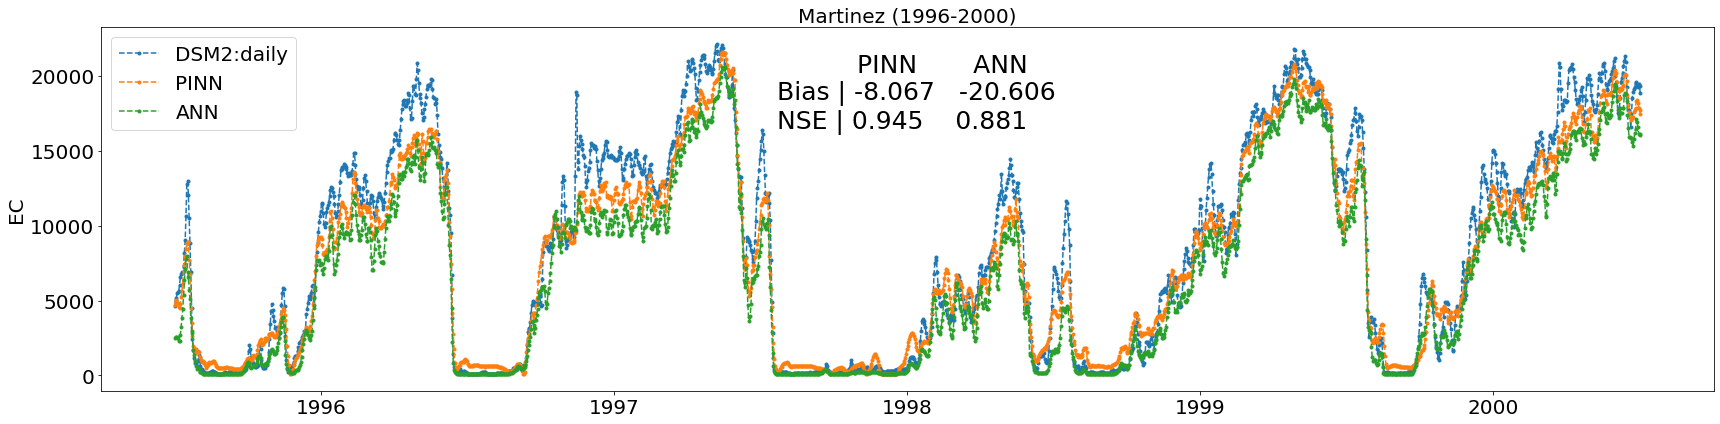

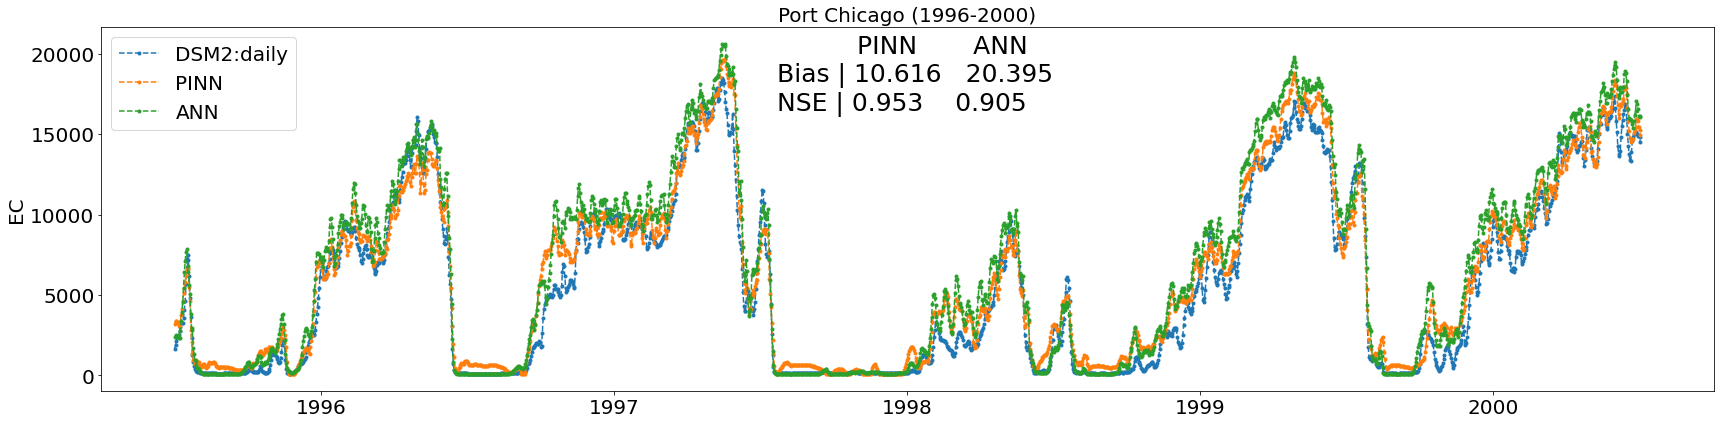

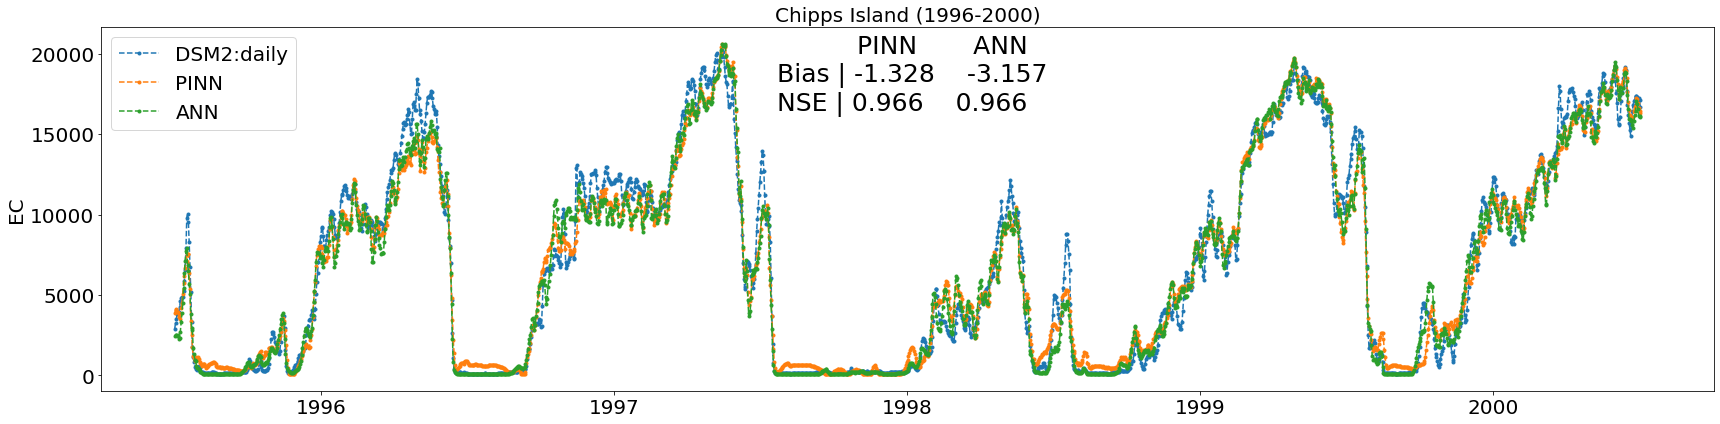

In [ ]:
fig1, fig2, fig3 = plotter2(2, RESULTS2, 750, 16500, ['1996','1997','1998','1999','2000'])